In [1]:
import pandas as pd
import numpy  as np
from os import listdir
from os.path import isfile, join
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import data_tools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import least_squares
from scipy import stats
import statsmodels.api as sm
import calendar
from my_time_series import (
    fit_AR_LS,
    residuals_AR,
    tests_gaussian_white_noise, 
)

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import data_tools
import itertools

from matplotlib import cm
from scipy.stats import norm
from Models.models import *
from time import time
from mpl_toolkits.mplot3d import axes3d, Axes3D
from datetime import datetime

from scipy.optimize import leastsq
import scipy.stats as spst
from numba import jit
from tabulate import tabulate
import scipy.fft
import math

import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter

%load_ext autoreload
%autoreload 2

/home/ignacio/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ignacio/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Load data

In [2]:
def initial_values(num_coefs):
    p0 = {}
    for i in range(num_coefs):
        p0[f'coefs{i}'] = 0
        
    return p0

class NLS:
    ''' This provides a wrapper for scipy.optimize.leastsq to get the relevant output for nonlinear least squares. 
    Although scipy provides curve_fit for that reason, curve_fit only returns parameter estimates and covariances. 
    This wrapper returns numerous statistics and diagnostics'''


    def __init__(self, func, p0, xdata, ydata):
        # Check the data
        if len(xdata) != len(ydata):
            msg = 'The number of observations does not match the number of rows for the predictors'
            raise ValueError(msg)

        # Check parameter estimates
        if type(p0) != dict:
            msg = "Initial parameter estimates (p0) must be a dictionry of form p0={'a':1, 'b':2, etc}"
            raise ValueError(msg)

        self.func  = func
        self.inits = list(p0.values())
        self.xdata = xdata
        self.ydata = ydata
        self.nobs  = len( ydata )
        self.nparm = len( self.inits )

        self.parmNames = p0.keys()

        # Run the model
        self.mod1 = leastsq(self.func, self.inits, full_output=1)

        # Get the parameters
        self.parmEsts = np.round( self.mod1[0], 4)

        # Get the Error variance and standard deviation
        self.RSS  = np.sum( self.mod1[2]['fvec']**2 ) # RSS
        self.df   = self.nobs - self.nparm            # degrees of freedom
        self.MSE  = self.RSS / self.df                # mean squared error
        self.RMSE = np.sqrt( self.MSE )               # root mean squared error

        # Get the covariance matrix
        self.cov = self.MSE * self.mod1[1] # it is not clear what mod1[1] is

        # Get parameter standard errors
        self.parmSE = np.sqrt( np.diag( self.cov ) )

        # Calculate the t-values
        self.tvals = self.parmEsts/self.parmSE

        # Get p-values
        self.pvals = (1 - spst.t.cdf( np.abs(self.tvals), self.df))*2

        # Get biased variance (MLE) and calculate log-likehood
        self.s2b = self.RSS / self.nobs
        self.logLik = -self.nobs/2 * np.log(2*np.pi) - self.nobs/2 * np.log(self.s2b) - 1/(2*self.s2b) * self.RSS

        del(self.mod1)
        del(self.s2b)
        del(self.inits)

    # Get AIC. Add 1 to the df to account for estimation of standard error
    def AIC(self, k=2):
        return -2*self.logLik + k*(self.nparm + 1)

    # Print the summary
    def summary(self):
        print('Non-linear least squares')
        print('Model: ' + self.func.__name__)
        table = [['Variable', 'Estimate', 'Std. Error', 't-value', 'P(>|t|)']]
        for i in range( len(self.parmNames) ):
                row = [f'{list(self.parmNames)[i]}', f'{self.parmEsts[i]:5.4f}', f'{self.parmSE[i]:5.4f}', f'{self.tvals[i]:5.4f}', f'{self.pvals[i]:5.4f}']
                table.append(row)
                
        print(tabulate(table, tablefmt='fancy_grid'))
        print(f'Residual Standard Error: {self.RMSE: 5.4f}')
        print(f'Df: {int(self.df)}')

In [3]:
ts = pd.read_csv('Preprocessed_data/ts.csv', index_col = 0)
ts = ts.set_index(pd.to_datetime(ts.index.values))

water_prices = pd.read_csv('water_prices.csv',index_col = 0)
water_prices = water_prices.set_index(np.array(list(map(lambda x: datetime( year = int(x.split('/')[2]), month = int(x.split('/')[0]), day = 15),water_prices.index.values))))
water_prices = water_prices.sort_index()
water_prices = water_prices / 1233.48 * 1e6 ## in USD per MCM

### Raw preprocess

In [73]:
dam_id = 1112

path = data_tools.from_id_to_time_series(dam_id)

dam_ts = pd.read_csv(path)
data_tools.add_year_month_database(dam_ts)

dam_ts = dam_ts.groupby('yearmonth').mean()

dam_ts.index = dam_ts.index.astype(int)

In [74]:
ele_ts = pd.read_csv('APUS37A72610.csv')

## Convert string to numeric and interpolate missings (2 missings in electricity prices)

for idx in range(len(ele_ts.APUS37A72610)):
    
    elem = ele_ts.APUS37A72610[idx]
    if elem == '.':
        a = ele_ts.APUS37A72610[idx-1]
        b = eval(ele_ts.APUS37A72610[idx+1])
        
        ele_ts.APUS37A72610[idx] = (a+b)/2
        
    else:
        ele_ts.APUS37A72610[idx] = eval(elem)
        
## Convert DATE to yearmonth

for idx in ele_ts.index:
        date = ele_ts.loc[idx,'DATE']
        date = date.split('-')

        if np.isnan(ele_ts.APUS37A72610[idx]):
            continue

        ele_ts.loc[idx,'yearmonth'] = eval(date[0] + date[1])
        
ele_ts = ele_ts.drop('DATE',axis=1)
ele_ts = ele_ts.set_index('yearmonth')
ele_ts.index = ele_ts.index.astype(int)

In [75]:
## set same time intervales for both series

new_index = dam_ts.index.intersection(ele_ts.index)

dam_ts = dam_ts.loc[new_index,:]
ele_ts = ele_ts.loc[new_index,:]

ts = ele_ts.merge(dam_ts, left_index=True, right_index=True)
ts = ts.rename(columns= {'APUS37A72610': 'price'})

In [76]:
yearmonth = list(ts.index)
x_label   = data_tools.from_index_to_dates(yearmonth)

In [77]:
ts = ts.iloc[301:,:]
x_label = x_label[301:]

prices_data = pd.read_csv('prices_processed.csv', index_col=0)
start = np.where(prices_data.index == 'Dec 2003')[0][0]
end   = np.where(prices_data.index == 'Jan 2020')[0][0]
new_prices = prices_data.iloc[start:end, -1].values

ts = ts.rename(columns={'price': 'price_power'})
ts.loc[:,'price_power'] = new_prices
ts = ts.set_index(np.array(list(map(lambda x: datetime( year = x // 100, month = x % 100, day = 15),ts.index.values))))

In [79]:
ts.to_csv('Preprocessed_data/ts.csv')

In [4]:
result = np.zeros(12)
for k in range(12):
    month = []
    for i in range(int(ts.shape[0]/12)):
        month.append(ts.price.values[12*i+k])
        
    result[k] = np.mean(month)

In [10]:
ts

,price_power,storage,inflow,outflow,elevation,evaporation,water_prices,log_diff_price_power,X,price_residual,storage_residual
2003-12-15,0.0687,2394.333419,28.737903,20.093000,174.512645,2.294,NaN,0.000000,0.000000,0.000000,0.000000
2004-01-15,0.0731,2423.144516,64.557774,38.687065,174.703871,2.294,NaN,0.062079,0.051039,0.000000,-92.904742
2004-02-15,0.0724,2556.166034,96.107276,46.154448,175.564310,2.945,NaN,-0.009622,-0.027772,0.000000,8.872992
2004-03-15,0.0727,2588.537645,79.366548,52.743226,175.769871,4.587,NaN,0.004135,-0.016889,0.000000,-72.639709
2004-04-15,0.0752,2638.082300,78.393133,37.528267,176.078700,5.578,NaN,0.033810,0.014916,0.000000,-50.623125
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-15,0.0945,2352.248000,21.151742,55.178516,174.229129,7.334,181632.454519,0.088455,0.101918,0.099887,-98.473293
2019-09-15,0.0909,2255.985500,20.976100,29.964867,173.568067,5.805,174011.739145,-0.038840,-0.022503,-0.053351,-97.087585
2019-10-15,0.0866,2202.691774,27.515710,9.802129,173.194258,3.964,195544.313649,-0.048460,-0.034254,-0.032852,-141.659504
2019-11-15,0.0852,2333.484000,83.207033,1.412100,174.099333,3.058,206051.172293,-0.016298,-0.008658,0.002721,-25.219404


In [6]:
yearmonth = list(ts.yearmonth)
x_label   = data_tools.from_index_to_dates(yearmonth)

## Fourier Transform 

In [4]:
normalize = lambda arr:(arr - np.mean(arr))/np.std(arr)

<ipython-input-5-cc85ac05b8c9>:10: RuntimeWarning: divide by zero encountered in true_divide
  new_X = 1/np.arange(0, f_nat, 1/new_N)
<ipython-input-5-cc85ac05b8c9>:24: RuntimeWarning: divide by zero encountered in true_divide
  new_X = 1/np.arange(0, f_nat, 1/new_N)
<ipython-input-5-cc85ac05b8c9>:38: RuntimeWarning: divide by zero encountered in true_divide
  new_X = 1/np.arange(0, f_nat, 1/new_N)
<ipython-input-5-cc85ac05b8c9>:52: RuntimeWarning: divide by zero encountered in true_divide
  new_X = 1/np.arange(0, f_nat, 1/new_N)


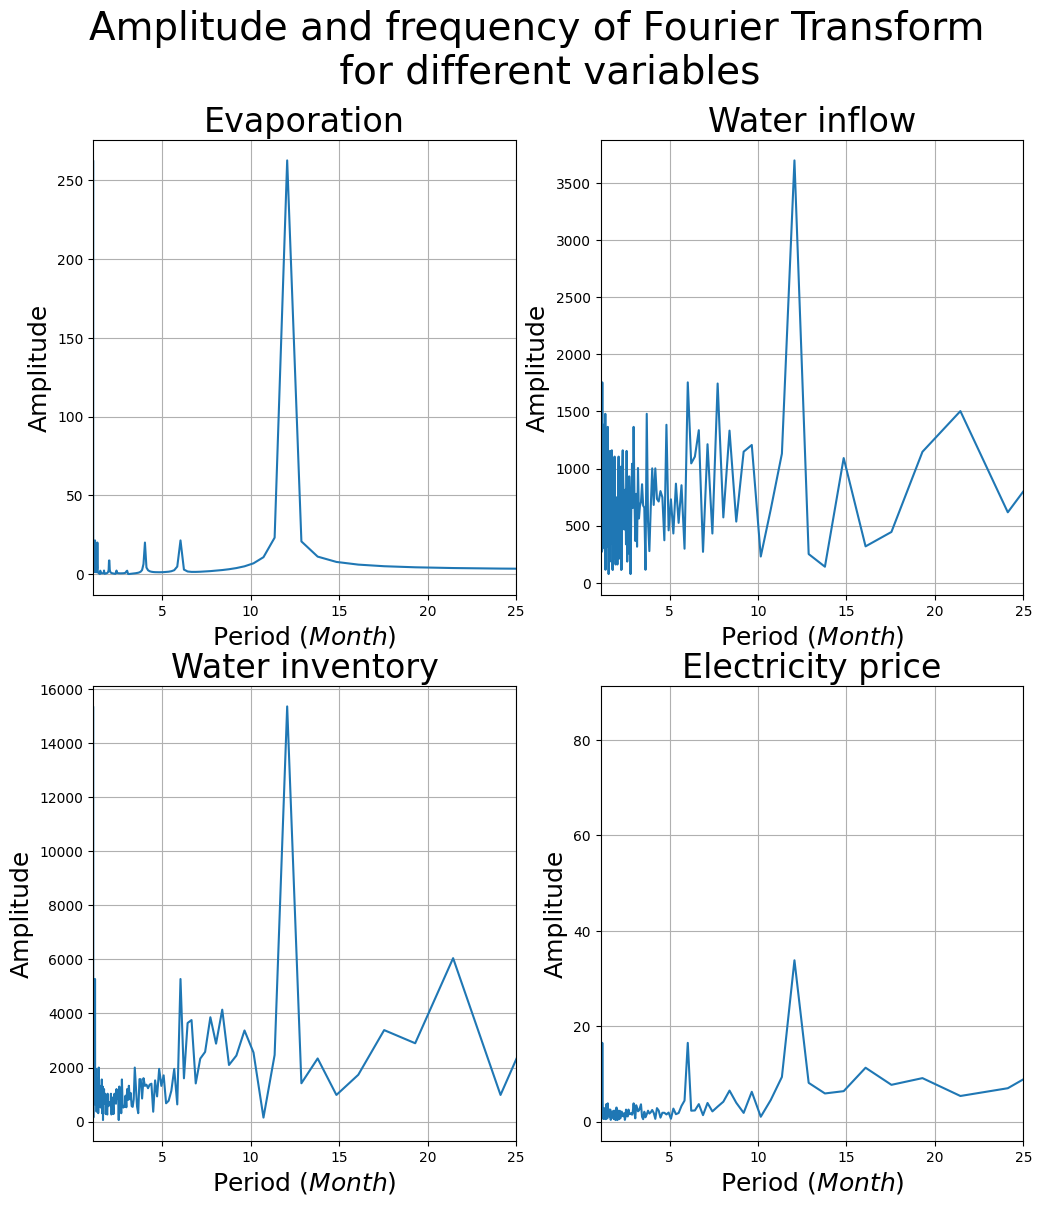

In [5]:
plt.figure(1, figsize=(12,13))

plt.suptitle('Amplitude and frequency of Fourier Transform \n for different variables', fontsize= 28)

plt.subplot(221)
FFT = scipy.fft.fft(ts.evaporation.values)
FFT_abs = np.abs(FFT)
new_N = len(FFT)
f_nat = 1
new_X = 1/np.arange(0, f_nat, 1/new_N)
#FFT_abs = normalize(FFT_abs)
plt.plot(new_X,FFT_abs[0:new_N])
plt.xlabel('Period ($Month$)',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
plt.title('Evaporation',fontsize=24)
plt.grid()
plt.xlim(1.1,25)

plt.subplot(222)
FFT = scipy.fft.fft(ts.inflow.values)
FFT_abs = np.abs(FFT)
new_N = len(FFT)
f_nat = 1
new_X = 1/np.arange(0, f_nat, 1/new_N)
#FFT_abs = normalize(FFT_abs)
plt.plot(new_X,FFT_abs[0:new_N])
plt.xlabel('Period ($Month$)',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
plt.title('Water inflow',fontsize=24)
plt.grid()
plt.xlim(1.1,25)

plt.subplot(223)
FFT = scipy.fft.fft(ts.storage.values)
FFT_abs = np.abs(FFT)
new_N = len(FFT)
f_nat = 1
new_X = 1/np.arange(0, f_nat, 1/new_N)
#FFT_abs = normalize(FFT_abs)
plt.plot(new_X,FFT_abs[0:new_N])
plt.xlabel('Period ($Month$)',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
plt.title('Water inventory',fontsize=24)
plt.grid()
plt.xlim(1.1,25)

plt.subplot(224)
FFT = scipy.fft.fft(ts.price.values)
FFT_abs = np.abs(FFT)
new_N = len(FFT)
f_nat = 1
new_X = 1/np.arange(0, f_nat, 1/new_N)
#FFT_abs = normalize(FFT_abs)
plt.plot(new_X,FFT_abs[0:new_N])
plt.xlabel('Period ($Month$)',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
plt.title('Electricity price',fontsize=24)
plt.grid()
plt.xlim(1.1,25)

plt.savefig('Figures/paper/fouriertransform.pdf', format = 'pdf')

plt.show()

In [26]:
w = 15
print(new_X[w])
print(FFT[w])
print(FFT_abs[w])

12.866666666666667
(-8.130971989517967+0.3210482830404007j)
8.137307754679613


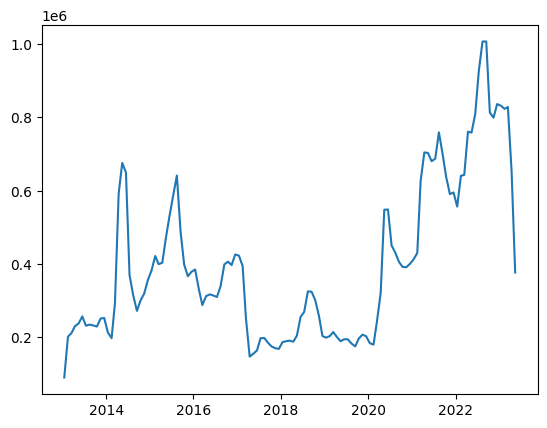

In [102]:
plt.plot(water_prices)
plt.show()

## Evaporation

In [7]:
def model_evaporation_0(coefs, t):
    return coefs[0] + coefs[1] * np.sin((coefs[2]+t)*2*np.pi/12)

evaporation = ts.evaporation.values
times       = np.arange(0,len(ts.index),1)

def residuals_evaporation(coefs):
    return model_evaporation_0(coefs, times) - evaporation

# coefs           = list(np.zeros(3))
# res_evaporation = least_squares(residuals_evaporation, coefs)
# coefficients_evaporation = res_evaporation.x
num_coefs = 3
p0 = initial_values(num_coefs)
res_evaporation = NLS(residuals_evaporation, p0, xdata=times, ydata=evaporation)

In [8]:
res_evaporation.summary()

Non-linear least squares
Model: residuals_evaporation
╒══════════╤══════════╤════════════╤═══════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value   │ P(>|t|) │
├──────────┼──────────┼────────────┼───────────┼─────────┤
│ coefs0   │ 4.9601   │ 0.0178     │ 278.3951  │ 0.0000  │
├──────────┼──────────┼────────────┼───────────┼─────────┤
│ coefs1   │ 2.7452   │ 0.0252     │ 108.9507  │ 0.0000  │
├──────────┼──────────┼────────────┼───────────┼─────────┤
│ coefs2   │ -2.5472  │ 0.0175     │ -145.3087 │ 0.0000  │
╘══════════╧══════════╧════════════╧═══════════╧═════════╛
Residual Standard Error:  0.2469
Df: 189


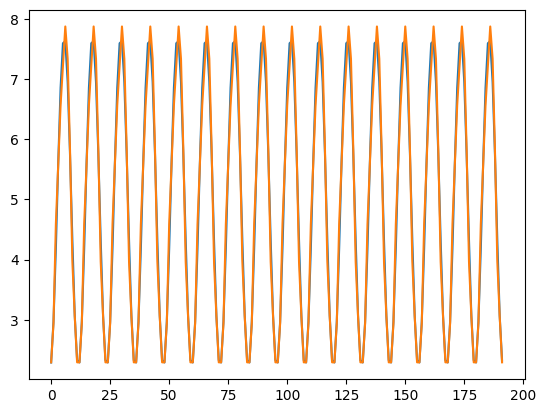

In [9]:
coefficients_evaporation = res_evaporation.parmEsts

np.savetxt('Models/coeficients/evaporation.csv', coefficients_evaporation, delimiter=',')

plt.plot(model_evaporation_0(coefficients_evaporation,times))
plt.plot(evaporation)
plt.show()

In [15]:
# Residuals 

residuals = model_evaporation_0(coefficients_evaporation,times) - evaporation

print(f'Evaporation residuals std: {np.std(residuals)}')

Evaporation residuals std: 0.24494001332739698


## Inflow

In [88]:
## Define the model.

inflows = ts.inflow.values
times   = np.arange(1,len(ts.index),1)

# def model_inflow_0(coefs,t):
#     return coefs[0]*inflows[t-1]+ coefs[1]*(1-coefs[0]) + (coefs[2] * (t% 12 == 1) + coefs[3] * (t% 12 == 2) + coefs[4] * (t% 12 == 3) \
#                                                            + coefs[5] * (t% 12 == 4) + coefs[6] * (t% 12 == 5) + coefs[7] * (t% 12 == 6)\
#                                                            + coefs[8] * (t% 12 == 7) + coefs[9] * (t% 12 == 8) + coefs[10] * (t% 12 == 9)\
#                                                            + coefs[11] * (t% 12 == 10)+ coefs[12] * (t% 12 == 11) + coefs[13] * (t% 12 == 0)) - coefs[0] \
#                                                            * (coefs[2] * (t-1% 12 == 1) + coefs[3] * (t-1% 12 == 2) + coefs[4] * (t-1% 12 == 3) \
#                                                            + coefs[5] * (t-1% 12 == 4) + coefs[6] * (t-1% 12 == 5) + coefs[7] * (t-1% 12 == 6)\
#                                                            + coefs[8] * (t-1% 12 == 7) + coefs[9] * (t-1% 12 == 8) + coefs[10] * (t-1% 12 == 9)\
#                                                            + coefs[11] * (t-1% 12 == 10)+ coefs[12] * (t-1% 12 == 11) + coefs[13] * (t% 12 == 0))

def model_inflow_0(coefs,t):
    return coefs[0] + coefs[1]* inflows[t-1] + coefs[2] * (np.sin((t+coefs[3])*2*np.pi/12))



def residuals_inflow(coefs):
    return model_inflow_0(coefs, times) - inflows[1:]

num_coefs = 4
p0 = initial_values(num_coefs)
inflow_res = NLS(residuals_inflow, p0, xdata=times, ydata=inflows[1:])

In [89]:
inflow_res.summary()

Non-linear least squares
Model: residuals_inflow
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 51.7650  │ 6.4057     │ 8.0810  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ 0.2048   │ 0.0716     │ 2.8610  │ 0.0047  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ 31.3252  │ 6.5748     │ 4.7644  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs3   │ 1.3272   │ 0.3918     │ 3.3878  │ 0.0009  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  60.7318
Df: 187


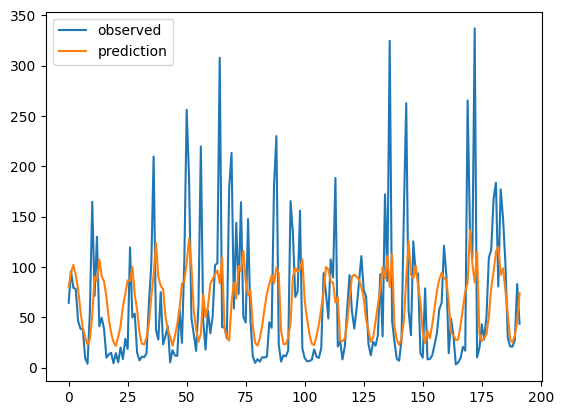

In [18]:
coefficients_inflow = inflow_res.parmEsts

np.savetxt('Models/coeficients/inflow_coef.csv', coefficients_inflow, delimiter=',')
np.savetxt('Models/coeficients/inflows.csv', inflows, delimiter=',')

plt.plot(inflows, label = 'observed')
plt.plot(model_inflow_0(coefficients_inflow,times), label = 'prediction')
plt.legend()
plt.show()

In [19]:
# Residuals 

residuals = model_inflow_0(coefficients_inflow,times[1:]) - inflows[1:]

print(f'Inflow residuals std: {np.std(residuals)}')

Inflow residuals std: 60.092621369282455


## Model storage

In [20]:
times   = np.arange(0,len(ts.index),1)

def model_storage_0(t):
    inflow      = model_inflow_0(coefficients_inflow, t)
    evaporation = model_evaporation_0(coefficients_evaporation,t)
    
    return ts.storage.values[t-1] + 2.592 * inflow - evaporation -  2.592 * ts.outflow.values[t-1]

In [21]:
prediction = model_storage_0(times[1:])

<ipython-input-75-6780eed51506>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l)


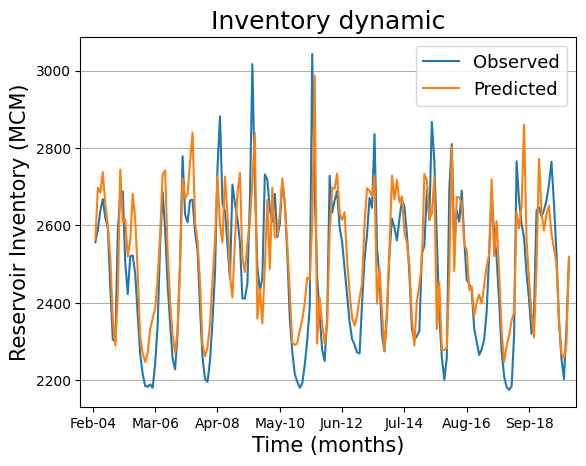

In [75]:
plt.plot(times[1:], ts.storage[1:],label = 'Observed')
plt.plot(times[1:], prediction[:],label = 'Predicted')
plt.locator_params(axis='x', nbins=8)
plt.xlim(-5,194)
ax = plt.gca()
x = ax.get_xticks
l = []
for e in x()[:]:
    year, month = divmod(int(e) + 1, 12)
    year  += 4
    if year < 10:
        year = f'0{year}'
    month += 1
    month = calendar.month_name[month][:3]
    l.append(f'{month}-{year}')
ax.set_xticklabels(l)
plt.grid(axis='y')
plt.title('Inventory dynamic', fontdict={'size': 18})
plt.xlabel('Time (months)',fontdict={'size':15})
plt.ylabel('Reservoir Inventory (MCM)',fontdict={'size':15})
plt.legend(fontsize = 13)
plt.savefig('Figures/paper/Inventory_dynamic.pdf', format = 'pdf')
plt.show()

In [23]:
# Residuals 

residuals = ts.storage[1:] - prediction

print(f'Storage residuals std: {np.std(residuals)}')

Storage residuals std: 103.79512935238394


## Electricity prices

In [ ]:
prices = ts.price.values
times  = np.arange(1,len(prices),1)

### Linear regression, integration

In [8]:
x = np.array(prices[:-1])
x = x.transpose()

In [16]:
x = sm.add_constant(x)
result = sm.OLS(prices[1:], x).fit()

In [10]:
sigma = np.cov(prices[1:], prices[:-1])

beta_hat = sigma[0,1]/(sigma[1,1])
print(beta_hat)

0.9473261611517437


In [18]:
v_hat = np.inner(result.resid, result.resid) / (len(result.resid) - 2)

dif_mean    = prices[:-1] - np.mean(prices[:-1])
denominator = np.inner(dif_mean, dif_mean)

error_beta = np.sqrt(v_hat / denominator)

print(error_beta)

0.02141573581383853


In [19]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1957.
Date:                Mon, 28 Nov 2022   Prob (F-statistic):          1.19e-101
Time:                        16:52:35   Log-Likelihood:                -17.180
No. Observations:                 191   AIC:                             38.36
Df Residuals:                     189   BIC:                             44.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4822      0.195      2.474      0.0

### It is not clear wether differentiation is needed or not, we will differentiate to make sure it is stationary

In [23]:
prices          = ts.price.values
log_prices      = np.log(prices)
diff_log_prices = np.diff(log_prices)

times = np.arange(1,len(prices),1)

In [21]:
%%latex

We fit the two models observed in the fishery paper:
    
\begin{equation}
\Delta ln(P_{t+1}) = \nu_P + \sigma_P \epsilon_{t+1}^P
\end{equation}

\begin{equation}
\Delta ln(P_{t+1}) = \theta_P \; (\mu_P - ln(P_t)) + \sigma_P \epsilon_{t+1}^P
\end{equation}

<IPython.core.display.Latex object>

#### First model

In [24]:
x            = np.ones(len(diff_log_prices))
result_nonmr = sm.OLS(diff_log_prices, x).fit()

In [23]:
np.savetxt('Models/coeficients/log_diff_prices_nonmr.csv', result_nonmr.params, delimiter=',')

In [25]:
print(result_nonmr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 28 Nov 2022   Prob (F-statistic):                nan
Time:                        16:53:48   Log-Likelihood:                 405.80
No. Observations:                 191   AIC:                            -809.6
Df Residuals:                     190   BIC:                            -806.3
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.311      0.7

In [26]:
np.std(result_nonmr.resid)

0.028911043385393458

#### Second model

In [27]:
x         = sm.add_constant(log_prices[:-1])
result_mr = sm.OLS(diff_log_prices, x).fit()

In [28]:
np.savetxt('Models/coeficients/log_diff_prices_mr.csv', result_mr.params, delimiter=',')

In [29]:
print(result_mr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     6.662
Date:                Mon, 28 Nov 2022   Prob (F-statistic):             0.0106
Time:                        16:54:31   Log-Likelihood:                 409.11
No. Observations:                 191   AIC:                            -814.2
Df Residuals:                     189   BIC:                            -807.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1223      0.047      2.593      0.0

In [30]:
np.std(result_mr.resid)

0.02841456267865391

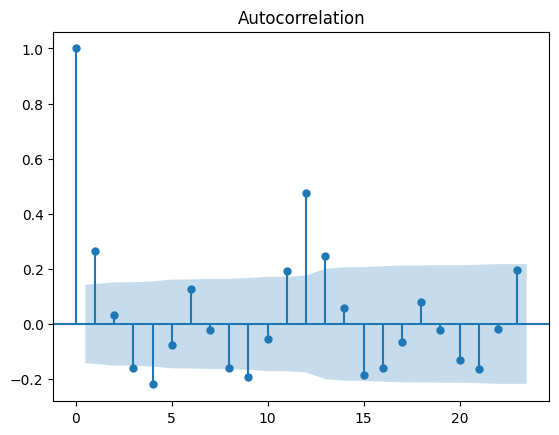

In [31]:
plot_acf(result_mr.resid)
plt.show()

### Fit sinusoidal

In [ ]:
prices = ts.price.values
times  = np.arange(1,len(prices),1)

In [47]:
def model_cte(coefs,t):
    return prices[t-1] + coefs[0] +  coefs[1] * (np.sin((t+coefs[2])*2*np.pi/6))
    
def residuals_prices_cte(coefs):
    return model_cte(coefs, times[:]) - prices[1:]

def model_rever(coefs,t):
    return prices[t-1] + coefs[0] +  coefs[1] * prices[t-1] + coefs[2] * (np.sin((t+coefs[3])*2*np.pi/6))
    
def residuals_prices_rever(coefs):
    return model_rever(coefs, times[:]) - prices[1:]

num_coefs = 3
p0 = initial_values(num_coefs)
results_noncorrelated_residuals = NLS(residuals_prices_cte, p0, xdata=times, ydata=prices[1:])

num_coefs = 4
p0 = initial_values(num_coefs)
results_correlated_residuals = NLS(residuals_prices_rever, p0, xdata=times, ydata=prices[1:])

In [48]:
results_correlated_residuals.summary()

Non-linear least squares
Model: residuals_prices_rever
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 0.4346   │ 0.1702     │ 2.5538  │ 0.0114  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ -0.0472  │ 0.0187     │ -2.5215 │ 0.0125  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ 0.1828   │ 0.0239     │ 7.6358  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs3   │ 0.8886   │ 0.1256     │ 7.0731  │ 0.0000  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  0.2340
Df: 188


In [49]:
results_noncorrelated_residuals.summary()

Non-linear least squares
Model: residuals_prices_cte
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 0.0073   │ 0.0171     │ 0.4263  │ 0.6704  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ 0.1871   │ 0.0242     │ 7.7256  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ 0.9250   │ 0.1236     │ 7.4848  │ 0.0000  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  0.2373
Df: 189


In [50]:
np.savetxt('Models/coeficients/prices_cte.csv', results_noncorrelated_residuals.parmEsts, delimiter=',')
np.savetxt('Models/coeficients/prices_rever.csv', results_correlated_residuals.parmEsts, delimiter=',')

In [51]:
resid_struc    = - residuals_prices_cte(results_noncorrelated_residuals.parmEsts)
print(f'The standard error (without error structures) is: {np.std(resid_struc)}')

resid_unestruc = - residuals_prices_rever(results_correlated_residuals.parmEsts)
print(f'The standard error (with error structure) is: {np.std(resid_unestruc)}')

The standard error (without error structures) is: 0.23542872625840602
The standard error (with error structure) is: 0.23154126017646431


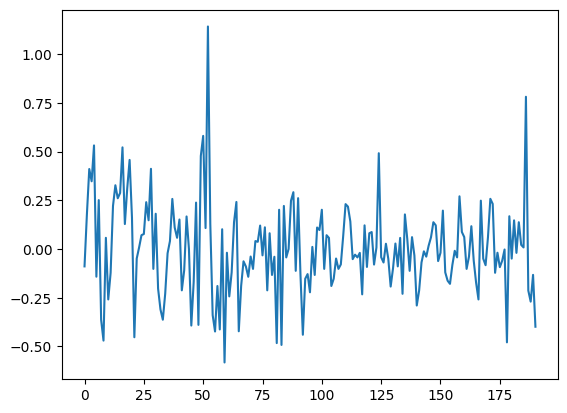

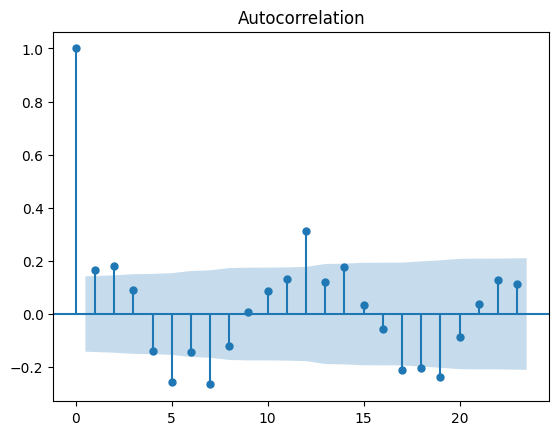

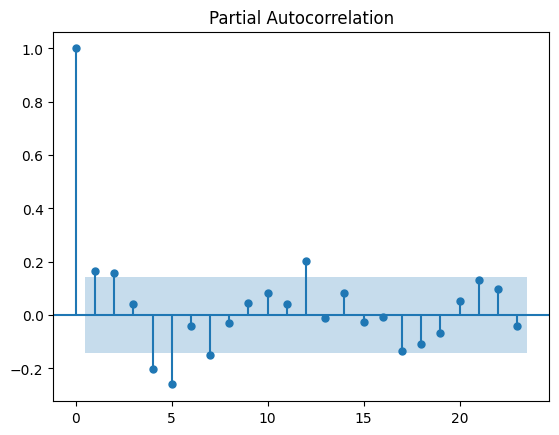

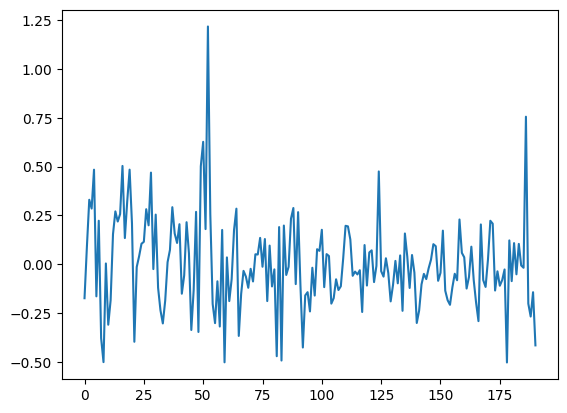

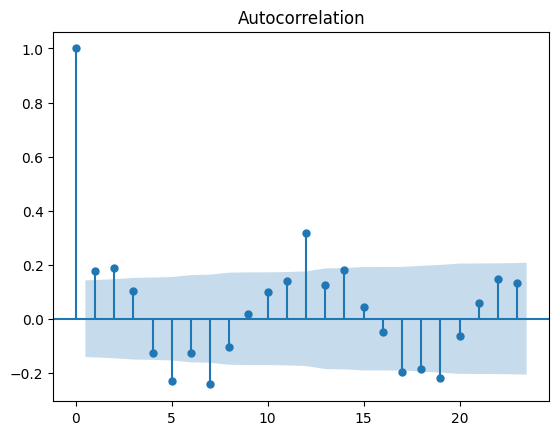

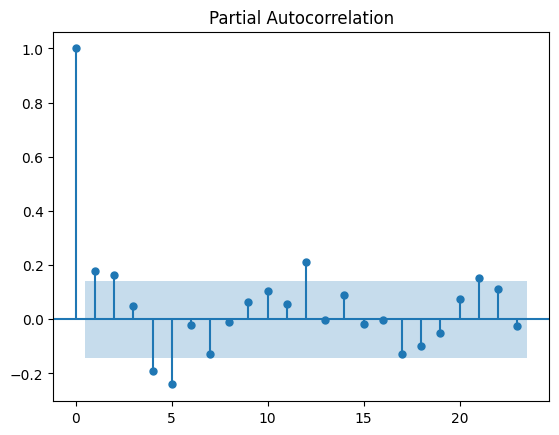

In [181]:
for resid in [resid_struc, resid_unestruc]:
    plt.plot(resid)
    plt.show()
    plot_acf(resid)
    plt.show()
    plot_pacf(resid)
    plt.show()

#### Testing different periods

In [52]:
def model_cte(coefs,t):
    return prices[t-1] + coefs[0] +  coefs[1] * (np.sin((t+coefs[2])*2*np.pi/12)) 
    
def residuals_prices_cte(coefs):
    return model_cte(coefs, times[:]) - prices[1:]

def model_rever(coefs,t):
    return prices[t-1] + coefs[0] +  coefs[1] * prices[t-1] + coefs[2] * (np.sin((t+coefs[3])*2*np.pi/12)) 
    
def residuals_prices_rever(coefs):
    return model_rever(coefs, times[:]) - prices[1:]

num_coefs = 3
p0 = initial_values(num_coefs)
results_noncorrelated_residuals = NLS(residuals_prices_cte, p0, xdata=times, ydata=prices[1:])

num_coefs = 4
p0 = initial_values(num_coefs)
results_correlated_residuals = NLS(residuals_prices_rever, p0, xdata=times, ydata=prices[1:])

In [53]:
results_correlated_residuals.summary()
results_noncorrelated_residuals.summary()

Non-linear least squares
Model: residuals_prices_rever
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 0.4607   │ 0.1801     │ 2.5576  │ 0.0113  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ -0.0501  │ 0.0198     │ -2.5278 │ 0.0123  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ 0.1651   │ 0.0246     │ 6.7148  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs3   │ -2.2258  │ 0.2948     │ -7.5498 │ 0.0000  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  0.2405
Df: 188
Non-linear least squares
Model: residuals_prices_cte
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 0.0073   │ 0.0176     │ 0.4147  │ 0.6789

In [44]:
prices = ts.price_power.values / 100
times  = np.arange(1,len(prices),1)

def model_2_cte(coefs,t):
    return prices[t-1] + coefs[0] +  coefs[1] * (np.sin((t+coefs[2])*2*np.pi/6)) + coefs[3] * (np.sin((t+coefs[4])*2*np.pi/12))
    
def residuals_prices_cte_2(coefs):
    return model_2_cte(coefs, times[:]) - prices[1:]

def model_2_rever(coefs,t):
    return prices[t-1] + coefs[0] +  coefs[1] * prices[t-1] + coefs[2] * (np.sin((t+coefs[3])*2*np.pi/6)) + coefs[4] * (np.sin((t+coefs[5])*2*np.pi/12))    

def residuals_prices_rever_2(coefs):
    return model_2_rever(coefs, times[:]) - prices[1:]

num_coefs = 5
p0 = initial_values(num_coefs)
results_noncorrelated_residuals_2 = NLS(residuals_prices_cte_2, p0, xdata=times, ydata=prices[1:])

num_coefs = 6
p0 = initial_values(num_coefs)
results_correlated_residuals_2 = NLS(residuals_prices_rever_2, p0, xdata=times, ydata=prices[1:])

In [45]:
print(results_correlated_residuals_2.RMSE)
print(results_noncorrelated_residuals_2.RMSE)

0.0020295022531839645
0.0020533845309706894


In [46]:
results_correlated_residuals_2.summary()
results_noncorrelated_residuals_2.summary()

Non-linear least squares
Model: residuals_prices_rever_2
╒══════════╤══════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate │ Std. Error │ t-value │ P(>|t|) │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 0.0036   │ 0.0015     │ 2.3450  │ 0.0201  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs1   │ -0.0394  │ 0.0169     │ -2.3323 │ 0.0208  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs2   │ 0.0018   │ 0.0002     │ 8.6667  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs3   │ 0.8948   │ 0.1086     │ 8.2393  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs4   │ 0.0017   │ 0.0002     │ 8.1910  │ 0.0000  │
├──────────┼──────────┼────────────┼─────────┼─────────┤
│ coefs5   │ -2.1829  │ 0.2477     │ -8.8138 │ 0.0000  │
╘══════════╧══════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  0.0020
Df: 186
Non-linear least squares
Model: residuals_price

In [47]:
np.savetxt('Models/coeficients/prices_2_cte.csv', results_noncorrelated_residuals_2.parmEsts, delimiter=',')
np.savetxt('Models/coeficients/prices_2_rever.csv', results_correlated_residuals_2.parmEsts, delimiter=',')

### Water prices model

In [4]:
FFT = scipy.fft.fft(prices)
FFT_abs = np.abs(FFT)
new_N = len(FFT)
f_nat = 1
new_X = 1/np.arange(0, f_nat, 1/new_N)
#FFT_abs = normalize(FFT_abs)
plt.plot(new_X,FFT_abs[0:new_N])
plt.xlabel('Period ($Month$)',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)
plt.title('Water price',fontsize=24)
plt.grid()
plt.xlim(1.1,25)
plt.tight_layout()
plt.show()

NameError: name 'prices' is not defined

In [5]:
water_model = 'seasonal'

if water_model == 'original':
    prices     = water_prices['Last Price'].values
    log_prices = np.log(prices)
    times      = np.arange(1,len(log_prices),1)

    def model_water(coefs,t):
        return coefs[0] * (coefs[1] - log_prices[t-1])

    def residuals_water(coefs):
        return model_water(coefs, times) - log_prices[1:]

    num_coefs = 2
    p0 = initial_values(num_coefs)
    result_water_model = NLS(residuals_water, p0, xdata=times, ydata= log_prices[1:])
    
if water_model == 'diff_brownian':
    prices     = water_prices['Last Price'].values
    diff_prices = np.diff(prices)
    times      = np.arange(0,len(diff_prices),1)

    def model_water(coefs,t):
        return coefs[0]

    def residuals_water(coefs):
        return model_water(coefs, times) - diff_prices

    num_coefs = 1
    p0 = initial_values(num_coefs)
    result_water_model = NLS(residuals_water, p0, xdata=times, ydata= diff_prices)
    
if water_model == 'diff_log_brownian':
    prices     = water_prices['Last Price'].values
    diff_prices = np.diff(prices) / prices[:-1]
    times      = np.arange(0,len(diff_prices),1)

    def model_water(coefs,t):
        return coefs[0]

    def residuals_water(coefs):
        return model_water(coefs, times) - diff_prices

    num_coefs = 1
    p0 = initial_values(num_coefs)
    result_water_model = NLS(residuals_water, p0, xdata=times, ydata= diff_prices)
    
if water_model == 'seasonal':
    
    prices     = water_prices['Last Price'].values
    diff_prices = np.diff(prices)
    times      = np.arange(0,len(diff_prices),1)

    def model_water(coefs,t):
        return coefs[0] + coefs[1] * (np.sin((t+coefs[2])*2*np.pi/12))

    def residuals_water(coefs):
        return model_water(coefs, times) - diff_prices

    num_coefs = 3
    p0 = initial_values(num_coefs)
    result_water_model = NLS(residuals_water, p0, xdata=times, ydata= diff_prices)

In [7]:
result_water_model.summary()
water_prices_sd = np.sqrt(result_water_model.MSE)

Non-linear least squares
Model: residuals_water
╒══════════╤════════════╤════════════╤═════════╤═════════╕
│ Variable │ Estimate   │ Std. Error │ t-value │ P(>|t|) │
├──────────┼────────────┼────────────┼─────────┼─────────┤
│ coefs0   │ 1793.8183  │ 6424.9177  │ 0.2792  │ 0.7806  │
├──────────┼────────────┼────────────┼─────────┼─────────┤
│ coefs1   │ 19583.3002 │ 9027.0136  │ 2.1694  │ 0.0320  │
├──────────┼────────────┼────────────┼─────────┼─────────┤
│ coefs2   │ 1.1687     │ 0.8914     │ 1.3111  │ 0.1923  │
╘══════════╧════════════╧════════════╧═════════╧═════════╛
Residual Standard Error:  71493.4580
Df: 121


In [8]:
np.savetxt('Models/coeficients/prices_water_v0.csv', result_water_model.parmEsts, delimiter=',')

## IV-function implementation

### Preprocessing

In [9]:
ts = pd.read_csv('Preprocessed_data/ts.csv', index_col = 0)
ts['water_prices'] = water_prices
ts.price_power = ts.price_power / 100
ts = ts.set_index(pd.to_datetime(ts.index.values))

water_prices = pd.read_csv('water_prices.csv',index_col = 0)
water_prices = water_prices.set_index(np.array(list(map(lambda x: datetime( year = int(x.split('/')[2]), month = int(x.split('/')[0]), day = 15),water_prices.index.values))))
water_prices = water_prices.sort_index()
water_prices = water_prices / 1233.48 * 1e6 ## in USD per MCM

log_diff_price_power = ts.price_power.values
log_diff_price_power = np.array(log_diff_price_power, dtype=float)
log_diff_price_power = np.diff(np.log(log_diff_price_power))
log_diff_price_power = np.concatenate((np.array([0]), log_diff_price_power))
ts['log_diff_price_power'] = log_diff_price_power

ts['X']                = np.zeros(ts.shape[0])
ts['price_residual']   = np.zeros(ts.shape[0])
ts['storage_residual'] = np.zeros(ts.shape[0])

for t_idx, t in enumerate(ts.index):
    if t_idx == 0:
        continue
        
    prev_t = ts.index[t_idx - 1]
    #storage residuals
    
    pred_storage = model_storage(model_inflow, ts.loc[prev_t,'inflow'] , model_evaporation, t.month, ts.loc[prev_t,'storage'], ts.loc[t,'outflow'])
    
    ts.loc[t,'storage_residual'] = ts.loc[t,'storage'] - pred_storage
    
    #prices residuals
        
    curr_price = ts.loc[t     , 'price_power']
    prev_price = ts.loc[prev_t, 'price_power']
    
    if t_idx < 12:
        ts.loc[t,'X'] = residual(prev_price,curr_price,t.month)
        ts.loc[t,'price_residual'] = 0
        continue
    
    prev_y_t = ts.index[t_idx - 12]
    
    prev_x   = ts.loc[prev_t  ,'X']
    prev_y_x = ts.loc[prev_y_t,'X']
    
    ts.loc[t,'X'] = residual(prev_price, curr_price, t.month)
    
    expected_X = mean_rever(prev_x,prev_y_x)
    
    ts.loc[t,'price_residual'] = residual_with_X(prev_price,curr_price,expected_X,t.month)
    

# correlation between residuals:

storage_res = ts['storage_residual'].values
prices_res  = ts['price_residual'  ].values

correlation = np.corrcoef(ts['storage_residual'].values[12:], ts['price_residual'].values[12:])[0,1]

eta = 9000
zd  = 105.69451612903225
r   = 0.0041

discount = 1/(1+r)

elev_stor = zip(ts.elevation.values,ts.storage.values)
elev_stor = sorted(elev_stor, key=lambda x: (x[1],x[0]))

### Function

In [10]:
def get_middle_points(x):
    x = np.array(x)
    return (x[:-1] + x[1:])/2


def pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation):
    
    expected_storage = model_storage(model_inflow, inflow , model_evaporation, t, storage, q) # this may not be needed if forecast is done.
    return eta * q * ((z(storage, elev_stor) + z(expected_storage,elev_stor))/2 - zd) * P

def pi_call_0(storage, inflow, t, P, q):
    if storage > 2e4 or storage < 3e4: # this must be wrong
        return pi_fun(storage, inflow, t, P, q, model_inflow, model_evaporation) 
    else:
        return -1e7
    
def prepro_coord_array(x,y):
    
    cond_storage = np.logical_or(x<storage_grid[0], x>storage_grid[-1])
    x[x<storage_grid[0]]  = storage_grid[0]
    x[x>storage_grid[-1]] = storage_grid[-1]
    
    cond_price = np.logical_or(y<price_grid[0], y>price_grid[-1])
    y[y<price_grid[0] ] = price_grid[0]
    y[y>price_grid[-1]] = price_grid[-1]
    #cond_price = np.logical_or(x<price_grid[0], x>price_grid[-1])

    return x,y, cond_storage, cond_price


def future_payments(V,A,shocks_storage, shocks_price, input_next_storage, input_next_price, price_grid, storage_grid,boundaries,ts_forecast):
    K = len(shocks_storage)
    J = len(shocks_price  )
    
    future_payment = np.zeros((K,J))
        
    future_storage = next_storage(*input_next_storage, shocks_storage)
    cond = np.logical_or(future_storage < boundaries[0], future_storage > boundaries[1])
    
    ###################
    
    future_price = next_price_cte(  *input_next_price  , shocks_price) # adjust the price model
#     future_price = next_price_rever(  *input_next_price  , shocks_price) # adjust the price model
    
    ################3
    
    cond = np.meshgrid(cond,future_price)[0]
    
    under_storage = False
    over_storage  = False
    
    if future_storage.min() < boundaries[0]:
        under_storage = True
        over_storage  = False
        
    elif future_storage.max() > boundaries[1]:
        under_storage = False
        over_storage  = True
    
    
    future_storage, future_price, cond_storage, cond_price = prepro_coord_array(future_storage, future_price)
    future_storage_upper, future_price_upper = coord_array_upper(future_storage, future_price,cond_storage, cond_price) # at this point future_price is the coord in V
    future_storage_lower, future_price_lower = coord_array_lower(future_storage, future_price)
    future_storage_closest, future_price_closest = coord_array(future_storage, future_price) # at this point future_price is the coord in V
    
    #print(future_price_closest)
    
    future_storage_upper[cond_storage] = future_storage_closest[cond_storage]
    future_price_upper[cond_price] = future_price_closest[cond_price]
    future_storage_exact, future_price_exact = coord_array_exact(future_storage, future_price)
        
    weight_storage = np.ones(K) - future_storage_exact + future_storage_lower
    weight_price   = np.ones(J) - future_price_exact   + future_price_lower
    
    W_storage = np.outer(weight_storage, np.ones(K))
    W_price   = np.outer(weight_price,   np.ones(J))
    W = (W_storage + W_price)/2
    
    future_storage_lower_cd ,future_price_lower_cd = np.meshgrid(future_storage_lower, future_price_lower)
    future_storage_upper_cd ,future_price_upper_cd = np.meshgrid(future_storage_upper, future_price_upper)

    future_value = W * V[future_storage_lower_cd, future_price_lower_cd] + (-W + 1) * V[future_storage_upper_cd, future_price_upper_cd]
    
    future_payment = np.multiply(future_value, A)
    
    return np.sum(future_payment[~cond]), under_storage, over_storage

def action_value(input_next_storage, input_next_price, V0, A, shocks_storage, shocks_prices, price_grid, storage_grid, boundaries, ts_forecast):
    
    s_next = (s+1)
    next_state_value, under_storage, over_storage = future_payments(V0[s_next],A, shocks_storage, shocks_prices,
                                                            input_next_storage, input_next_price, 
                                                            price_grid, storage_grid, boundaries, ts_forecast)
    
    next_state_value = discount * next_state_value
    
    if under_storage or over_storage: 
        return 0 + next_state_value
    else:
        q = input_next_storage[-2]
        return pi_call_0(storage, inflow, current_time, price, q) + next_state_value

def save_load_policy_V0(policy = None, V0 = None, cashflow_e = None, cashflow_w = None, mr = False, one_component = False,
                        save_results = False, load_results = False, directory = None):

    if save_results and policy.any() and V0.any():
        if one_component:
            if mr:
                policy.tofile('Results/policy_mr_model.txt')
                V0.tofile('Results/V0_mr_model.txt')
                cashflow_e.tofile('Results/cashflow_e_mr_model.txt')
                cashflow_w.tofile('Results/cashflow_w_mr_model.txt')

            else:
                policy.tofile('Results/policy_nonmr_model.txt')
                V0.tofile('Results/V0_nonmr_model.txt')
                cashflow_e.tofile('Results/cashflow_e_nonmr_model.txt')
                cashflow_w.tofile('Results/cashflow_w_nonmr_model.txt')
        else:
            if mr:
                policy.tofile('Results/policy_2_mr_model.txt')
                V0.tofile('Results/V0_2_mr_model.txt')
                cashflow_e.tofile('Results/cashflow_e_2_mr_model.txt')
                cashflow_w.tofile('Results/cashflow_w_2_mr_model.txt')

            else:
                policy.tofile('Results/policy_2_nonmr_model.txt')
                V0.tofile('Results/V0_2_nonmr_model.txt')
                cashflow_e.tofile('Results/cashflow_e_2_nonmr_model.txt')
                cashflow_w.tofile('Results/cashflow_w_2_nonmr_model.txt')

    if load_results:
        if one_component:

            if mr:
                mr_file = open("Results/policy_mr_model.txt")
                loaded_policy = np.fromfile(mr_file)
                loaded_policy = loaded_policy.reshape((S, N, M, W))
                mr_file.close()
                
                mr_file = open("Results/cashflow_e_mr_model.txt")
                loaded_cashflow_e = np.fromfile(mr_file)
                loaded_cashflow_e = loaded_cashflow_e.reshape((S, N, M, W))
                mr_file.close()
                
                mr_file = open("Results/cashflow_w_mr_model.txt")
                loaded_cashflow_w = np.fromfile(mr_file)
                loaded_cashflow_w = loaded_cashflow_w.reshape((S, N, M, W))
                mr_file.close()

                V0_mr = open("Results/V0_mr_model.txt")
                loaded_V0 = np.fromfile(V0_mr)
                loaded_V0 = loaded_V0.reshape((S+1, N, M, W))
                V0_mr.close()

            else:
                nonmr_file = open("Results/policy_nonmr_model.txt")
                loaded_policy = np.fromfile(nonmr_file)
                loaded_policy = loaded_policy.reshape((S, N, M, W))
                nonmr_file.close()
                
                nonmr_file = open("Results/cashflow_e_nonmr_model.txt")
                loaded_cashflow_e = np.fromfile(nonmr_file)
                loaded_cashflow_e = loaded_cashflow_e.reshape((S, N, M, W))
                nonmr_file.close()
                
                nonmr_file = open("Results/cashflow_w_nonmr_model.txt")
                loaded_cashflow_w = np.fromfile(nonmr_file)
                loaded_cashflow_w = loaded_cashflow_w.reshape((S, N, M, W))
                nonmr_file.close()

                V0_nonmr = open("Results/V0_nonmr_model.txt")
                loaded_V0 = np.fromfile(V0_nonmr)
                loaded_V0 = loaded_V0.reshape((S+1, N, M, W))
                V0_nonmr.close()
                
        else:
            if mr:
                mr_file = open("Results/policy_2_mr_model.txt")
                loaded_policy = np.fromfile(mr_file)
                loaded_policy = loaded_policy.reshape((S, N, M, W))
                mr_file.close()

                mr_file = open("Results/cashflow_e_2_mr_model.txt")
                loaded_cashflow_e = np.fromfile(mr_file)
                loaded_cashflow_e = loaded_cashflow_e.reshape((S, N, M, W))
                mr_file.close()
                
                mr_file = open("Results/cashflow_w_2_mr_model.txt")
                loaded_cashflow_w = np.fromfile(mr_file)
                loaded_cashflow_w = loaded_cashflow_w.reshape((S, N, M, W))
                mr_file.close()
                
                V0_mr = open("Results/V0_2_mr_model.txt")
                loaded_V0 = np.fromfile(V0_mr)
                loaded_V0 = loaded_V0.reshape((S+1, N, M, W))
                V0_mr.close()

            else:
                nonmr_file = open("Results/policy_2_nonmr_model.txt")
                loaded_policy = np.fromfile(nonmr_file)
                loaded_policy = loaded_policy.reshape((S, N, M, W))
                nonmr_file.close()
                
                nonmr_file = open("Results/cashflow_e_2_nonmr_model.txt")
                loaded_cashflow_e = np.fromfile(nonmr_file)
                loaded_cashflow_e = loaded_cashflow_e.reshape((S, N, M, W))
                nonmr_file.close()
                
                nonmr_file = open("Results/cashflow_w_2_nonmr_model.txt")
                loaded_cashflow_w = np.fromfile(nonmr_file)
                loaded_cashflow_w = loaded_cashflow_w.reshape((S, N, M, W))
                nonmr_file.close()

                V0_nonmr = open("Results/V0_2_nonmr_model.txt")
                loaded_V0 = np.fromfile(V0_nonmr)
                loaded_V0 = loaded_V0.reshape((S+1, N, M, W))
                V0_nonmr.close()
                
        return loaded_policy, loaded_V0, loaded_cashflow_e, loaded_cashflow_w
    return None
# def save_load_policy_V0(policy = None, V0 = None, save_results = False, load_results = False, mr = False, one_component = True):

#     if save_results and policy.any() and V0.any():
#         if one_component:
#             if mr:
#                 policy.tofile('Results/policy_mr_model.txt')
#                 V0.tofile('Results/V0_mr_model.txt')

#             else:
#                 policy.tofile('Results/policy_nonmr_model.txt')
#                 V0.tofile('Results/V0_nonmr_model.txt')
#         else:
#             if mr:
#                 policy.tofile('Results/policy_2_mr_model.txt')
#                 V0.tofile('Results/V0_2_mr_model.txt')

#             else:
#                 policy.tofile('Results/policy_2_nonmr_model.txt')
#                 V0.tofile('Results/V0_2_nonmr_model.txt')

#     if load_results:
#         if one_component:

#             if mr:
#                 mr_file = open("Results/policy_mr_model.txt")
#                 loaded_policy = np.fromfile(mr_file)
#                 loaded_policy = loaded_policy.reshape((S,N,M))
#                 mr_file.close()

#                 V0_mr = open("Results/V0_mr_model.txt")
#                 loaded_V0 = np.fromfile(V0_mr)
#                 loaded_V0 = loaded_V0.reshape((S+1,N,M))
#                 V0_mr.close()

#             else:
#                 nonmr_file = open("Results/policy_nonmr_model.txt")
#                 loaded_policy = np.fromfile(nonmr_file)
#                 loaded_policy = loaded_policy.reshape((S,N,M))
#                 nonmr_file.close()

#                 V0_nonmr = open("Results/V0_nonmr_model.txt")
#                 loaded_V0 = np.fromfile(V0_nonmr)
#                 loaded_V0 = loaded_V0.reshape((S+1,N,M))
#                 V0_nonmr.close()
                
#         else:
#             if mr:
#                 mr_file = open("Results/policy_2_mr_model.txt")
#                 loaded_policy = np.fromfile(mr_file)
#                 loaded_policy = loaded_policy.reshape((S,N,M))
#                 mr_file.close()

#                 V0_mr = open("Results/V0_2_mr_model.txt")
#                 loaded_V0 = np.fromfile(V0_mr)
#                 loaded_V0 = loaded_V0.reshape((S+1,N,M))
#                 V0_mr.close()

#             else:
#                 nonmr_file = open("Results/policy_2_nonmr_model.txt")
#                 loaded_policy = np.fromfile(nonmr_file)
#                 loaded_policy = loaded_policy.reshape((S,N,M))
#                 nonmr_file.close()

#                 V0_nonmr = open("Results/V0_2_nonmr_model.txt")
#                 loaded_V0 = np.fromfile(V0_nonmr)
#                 loaded_V0 = loaded_V0.reshape((S+1,N,M))
#                 V0_nonmr.close()
                
#         return loaded_policy, loaded_V0
#     return None



coord = lambda x,y: (int((x - storage_grid[0])/step_storage) * step_storage + storage_grid[0], int((y - price_grid[0])/step_price) * step_price + price_grid[0])

coord_array = lambda x,y: (((x - storage_grid[0])/step_storage + 0.5).astype(int), ((y - price_grid[0])/step_price + 0.5).astype(int))

coord_array_exact = lambda x,y: ((x - storage_grid[0])/step_storage, (y - price_grid[0])/step_price)

coord_array_upper = lambda x,y,x_cond,y_cond: (((x - storage_grid[0])/step_storage + 1*(~x_cond)).astype(int), ((y - price_grid[0])/step_price + 1*(~y_cond)).astype(int))

coord_array_lower = lambda x,y: (((x - storage_grid[0])/step_storage).astype(int), ((y - price_grid[0])/step_price ).astype(int))


@jit
def pi_fun_numba(storage, inflow, t, price_e, price_w, q):
    inflow  = coefs_inflow[0] + coefs_inflow[1]* inflow + coefs_inflow[2] * (np.sin((t+coefs_inflow[3])*2*np.pi/12))
    evapor  = coefs_evaporation[0] + coefs_evaporation[1] * np.sin((coefs_evaporation[2]+t)*2*np.pi/12) 
    expected_storage = storage + 2.592 * inflow - evapor -  2.592 * q
    return eta * q * 2.592 * ((z_numba(storage, elev_stor) + z_numba(expected_storage,elev_stor))/2 - zd) * price_e, price_w * q

@jit
def z_numba(I,elev_stor):
    if I <= elev_stor[0,1]:
        return elev_stor[0,0]

    if I >= elev_stor[-1,1]:
        return elev_stor[-1,0]

    for idx in range(1,len(elev_stor)):
        prev_storage = elev_stor[idx-1][1]
        curr_storage = elev_stor[idx][1]

        if prev_storage == curr_storage:
            continue

        if I >= prev_storage and I < curr_storage:
            prev_height = elev_stor[idx-1][0]
            curr_height = elev_stor[idx][0]

            return prev_height   + (curr_height-prev_height) * (I - prev_storage)/(curr_storage-prev_storage)


@jit
def meshgrid_numba(x, y):
    xx = np.empty(shape=(x.size, y.size), dtype=x.dtype)
    yy = np.empty(shape=(x.size, y.size), dtype=y.dtype)
    for j in range(y.size):
        for k in range(x.size):
            xx[j,k] = x[k]  # change to x[k] if indexing xy
            yy[j,k] = y[j] 
    return xx, yy

@jit
def coord_array_numba(x, grid, step):
    return ((x - grid[0])/step + 0.5).astype(np.int_)

@jit
def coord_array_exact_numba(x,grid, step):
    return (x - grid[0])/step

@jit
def coord_array_upper_numba(x,grid,x_cond,step):
    return ((x - grid[0])/step + 1*(~x_cond)).astype(np.int_)

@jit
def coord_array_lower_numba(x,grid, step):
    return ((x - grid[0])/step).astype(np.int_)

@jit
def prepro_coord_array_numba(x,grid):
    
    cond = np.logical_or(x<grid[0], x>grid[-1])
    x[x<grid[0]]  = grid[0]
    x[x>grid[-1]] = grid[-1]
    
    return x, cond

@jit
def next_storage_numba(prev_inflow, t, prev_storage, outflow, shock_n):
    inflow  = coefs_inflow[0] + coefs_inflow[1]* prev_inflow + coefs_inflow[2] * (sin((t+coefs_inflow[3])*2*pi/12))
    evapor  = coefs_evaporation[0] + coefs_evaporation[1] * sin((coefs_evaporation[2]+t)*2*pi/12) 
    storage = prev_storage + 2.592 * inflow - evapor -  2.592 * outflow
    return storage + storage_sd * shock_n

@jit
def model_prices_rever_numba(t,prev):
    return prev + coefs_prices_rever[0] +  coefs_prices_rever[1] * prev + coefs_prices_rever[2] * (np.sin((t+coefs_prices_rever[3])*2*np.pi/6))

@jit
def model_prices_cte_numba(t, prev):
    return prev + coefs_prices_cte[0] +  coefs_prices_cte[1] * (np.sin((t+coefs_prices_cte[2])*2*np.pi/6))

@jit
def next_price_rever_numba(t, prev, shock_m):
    return model_prices_rever_numba(t, prev)  + prices_rever_sd * shock_m
@jit
def next_price_cte_numba(t, prev, shock_m):
    return model_prices_cte_numba(t, prev)  + prices_cte_sd * shock_m

@jit
def model_prices_2_cte_numba(t,prev):
    return prev + coefs_prices_cte_2[0] +  coefs_prices_cte_2[1] * (np.sin((t+coefs_prices_cte_2[2])*2*np.pi/6)) + coefs_prices_cte_2[3] * (np.sin((t+coefs_prices_cte_2[4])*2*np.pi/12))
@jit
def next_price_2_cte_numba(t, prev, shock_m):
    return model_prices_2_cte_numba(t, prev)  + prices_2_cte_sd * shock_m
@jit
def model_prices_2_rever_numba(t,prev):
    return prev + coefs_prices_rever_2[0] +  coefs_prices_rever_2[1] * prev + coefs_prices_rever_2[2] * (np.sin((t+coefs_prices_rever_2[3])*2*np.pi/6)) + coefs_prices_rever_2[4] * (np.sin((t+coefs_prices_rever_2[5])*2*np.pi/12))

@jit
def next_price_2_rever_numba(t, prev, shock_m):
    return model_prices_2_rever_numba(t, prev)  + prices_2_rever_sd * shock_m

################################################### Water model ###################################################
coefs_water_prices = loadtxt('Models/coeficients/prices_water_v0.csv')

if water_model == 'original':
    
    @jit
    def model_water_prices_numba(prev,t):
        return np.exp(coefs_water_prices[0] * (coefs_water_prices[1] - np.log(prev)))

    @jit
    def next_water_price_numba(prev,t, shock_w):
        return np.exp(np.log(model_water_prices_numba(prev,t)) + water_prices_sd * shock_w)
    
if water_model == 'diff_brownian':
    
    @jit
    def model_water_prices_numba(prev,t):
        return prev + coefs_water_prices[0]

    @jit
    def next_water_price_numba(prev, t, shock_w):
        return model_water_prices_numba(prev,t) + water_prices_sd * shock_w
    
if water_model == 'diff_log_brownian':
    
    @jit
    def model_water_prices_numba(prev,t):
        return prev + coefs_water_prices[0] * prev

    @jit
    def next_water_price_numba(prev, t, shock_w):
        return model_water_prices_numba(prev, t) + prev * water_prices_sd * shock_w
    
if water_model == 'seasonal':
    
    @jit
    def model_water_prices_numba(prev,t):
        return prev + coefs_water_prices[0] + coefs_water_prices[1] * (np.sin((t+coefs_water_prices[2])*2*np.pi/12))

    @jit
    def next_water_price_numba(prev, t, shock_w):
        return model_water_prices_numba(prev, t) + water_prices_sd * shock_w
    




@jit
def gridding(future_storage,
             future_price_e,
             future_price_w,
             price_grid_e,
             price_grid_w,
             storage_grid,
             value):
    
    
    future_storage, cond_storage = prepro_coord_array_numba(future_storage, storage_grid)
    future_price_e, cond_price_e = prepro_coord_array_numba(future_price_e, price_grid_e)
    future_price_w, cond_price_w = prepro_coord_array_numba(future_price_w, price_grid_w)
            
    ## the condition is true if the value is out of the boundary
    
#     future_storage_upper = coord_array_upper_numba(future_storage, storage_grid, cond_storage, step_storage)
#     future_price_e_upper = coord_array_upper_numba(future_price_e, price_grid_e, cond_price_e, step_price_e)
#     future_price_w_upper = coord_array_upper_numba(future_price_w, price_grid_w, cond_price_w, step_price_w)
    
#     future_storage_lower = coord_array_lower_numba(future_storage, storage_grid, step_storage)
#     future_price_e_lower = coord_array_lower_numba(future_price_e, price_grid_e, step_price_e)
#     future_price_w_lower = coord_array_lower_numba(future_price_w, price_grid_w, step_price_w)
    
    future_storage_closest = coord_array_numba(future_storage, storage_grid, step_storage)
    future_price_e_closest = coord_array_numba(future_price_e, price_grid_e, step_price_e)
    future_price_w_closest = coord_array_numba(future_price_w, price_grid_w, step_price_w)

    #print(future_price_closest)
    
#     future_storage_upper[cond_storage] = future_storage_closest[cond_storage]
#     future_price_e_upper[cond_price_e] = future_price_e_closest[cond_price_e]        
#     future_price_w_upper[cond_price_w] = future_price_w_closest[cond_price_w]
                    
#     future_storage_exact = coord_array_exact_numba(future_storage, storage_grid, step_storage)        
#     future_price_e_exact = coord_array_exact_numba(future_price_e, price_grid_e, step_price_e)        
#     future_price_w_exact = coord_array_exact_numba(future_price_w, price_grid_w, step_price_w)
            
    # everything is in coordinates, so i can just work that here.
    
    future_value = np.zeros((K,J,L))
            
    for x in range(K):
        for y in range(J):
            for z in range(L):
                ##### Hay que meter las 8 sumas
                sol = 0
                sol = value[future_storage_closest[x], future_price_e_closest[y], future_price_w_closest[z]]
                
#                 sol += ((future_storage_upper[x] - future_storage_exact[x]) * (future_price_e_upper[y] - future_price_e_exact[y]) * 
#                 (future_price_w_upper[z] - future_price_w_exact[z]) * value[future_storage_upper[x], future_price_e_upper[y], future_price_w_upper[z]]  )# [1,1,1]
            
#                 sol += ((future_storage_upper[x] - future_storage_exact[x]) * (future_price_e_upper[y] - future_price_e_exact[y]) * 
#                 (future_price_w_lower[z] - future_price_w_exact[z]) * (-1) * value[future_storage_upper[x], future_price_e_upper[y], future_price_w_lower[z]] )# [1,1,0]
            
#                 sol += ((future_storage_upper[x] - future_storage_exact[x]) * (future_price_e_lower[y] - future_price_e_exact[y]) * (-1) *
#                 (future_price_w_upper[z] - future_price_w_exact[z]) * value[future_storage_upper[x], future_price_e_lower[y], future_price_w_upper[z]] )# [1,0,1]
            
#                 sol += ((future_storage_upper[x] - future_storage_exact[x]) * (future_price_e_lower[y] - future_price_e_exact[y]) * (-1) *
#                 (future_price_w_lower[z] - future_price_w_exact[z]) * (-1) * value[future_storage_upper[x], future_price_e_lower[y], future_price_w_lower[z]] )# [1,0,0]
            
#                 sol += ((future_storage_lower[x] - future_storage_exact[x]) * (-1) * (future_price_e_upper[y] - future_price_e_exact[y]) * 
#                 (future_price_w_upper[z] - future_price_w_exact[z]) * value[future_storage_lower[x], future_price_e_upper[y], future_price_w_upper[z]] )# [0,1,1]
            
#                 sol += ((future_storage_lower[x] - future_storage_exact[x]) * (-1) * (future_price_e_upper[y] - future_price_e_exact[y]) * 
#                 (future_price_w_lower[z] - future_price_w_exact[z]) * (-1) * value[future_storage_lower[x], future_price_e_upper[y], future_price_w_lower[z]] )# [0,1,0]
            
#                 sol += ((future_storage_lower[x] - future_storage_exact[x]) * (-1) * (future_price_e_lower[y] - future_price_e_exact[y]) * (-1) *
#                 (future_price_w_upper[z] - future_price_w_exact[z]) * value[future_storage_lower[x], future_price_e_lower[y], future_price_w_upper[z]])# [0,0,1]
            
#                 sol += ((future_storage_lower[x] - future_storage_exact[x]) * (-1) * (future_price_e_lower[y] - future_price_e_exact[y]) * (-1) *
#                 (future_price_w_lower[z] - future_price_w_exact[z]) * (-1) * value[future_storage_lower[x], future_price_e_lower[y], future_price_w_lower[z]] )# [0,0,0]
                
            
                future_value[x,y,z] = sol
    
    return future_value

@jit
def future_payments_numba(Value_next,
                          A,
                          shocks_storage,
                          shocks_prices_e,
                          shocks_prices_w,
                          prev_inflow,
                          current_time,
                          q,
                          storage,
                          price_e,
                          price_w,
                          price_grid_e,
                          price_grid_w,
                          storage_grid,
                          boundaries):
    
    #future_payment = np.zeros((K,J))
        
    future_storage = next_storage_numba(prev_inflow, current_time, storage, q, shocks_storage) # stays the same
    cond = np.logical_or(future_storage < boundaries[0], future_storage > boundaries[1])  # stays the same
    
    ###################
    
#     future_price = next_price_cte_numba( current_time, price  , shocks_price) # adjust the price model
#     future_price = next_price_rever_numba(current_time, price  , shocks_price) # adjust the price model
#     future_price = next_price_2_cte_numba( current_time, price  , shocks_price) # adjust the price model
    future_price_e = next_price_2_rever_numba(current_time, price_e  , shocks_prices_e) # adjust the price model
    
    ###################
    # add water price
    
    future_price_w = next_water_price_numba(price_w, (current_time - 1) % 12 , shocks_prices_w) ## make this to numba prolly.
    
    
    ###################    
        
    under_storage = False # stays the same
    over_storage  = False # stays the same
    
    if future_storage.min() < boundaries[0]: # stays the same
        under_storage = True # stays the same
        
    elif future_storage.max() > boundaries[1]: # stays the same
        over_storage  = True # stays the same
    
    # Calculate the value at each future state
    
#     future_storage_lower_cd, future_price_lower_cd, future_storage_upper_cd, future_price_upper_cd, W = gridding(future_storage, future_price) # Problem
    
#     future_value = np.zeros((K,J))
#     for idx_storage,_ in enumerate(future_storage_lower_cd[0,:]): # 1 more dimension
#         for idx_price,_ in enumerate(future_price_lower_cd[:,0]):
#             future_value[idx_storage,idx_price] = (W[idx_storage, idx_price] * Value_next[future_storage_lower_cd[idx_storage,idx_price],future_price_lower_cd[idx_storage,idx_price] ] + 
#             (1-W[idx_storage, idx_price]) * Value_next[future_storage_upper_cd[idx_storage,idx_price],future_price_upper_cd[idx_storage,idx_price]])
            
    future_value = gridding(future_storage = future_storage,
                            future_price_e = future_price_e,
                            future_price_w = future_price_w,
                            price_grid_e   = price_grid_e,
                            price_grid_w   = price_grid_w,
                            storage_grid   = storage_grid,
                            value          = Value_next )
    
    future_payment = np.multiply(future_value, A) # Element wise # stays the same
    
    # Compute the expected value and the value is 0 if it violates boundary conditions
    
    sol = 0
    
    for x in range(cond.shape[0]):
        if not cond[x]:
            sol += np.sum(future_payment[x,:,:])

    return sol, under_storage, over_storage
    
@jit
def action_value_numba(state, 
                        prev_inflow, 
                        current_time,
                        q,
                        storage,
                        price_e,
                        price_w,
                        V0,
                        A,
                        shocks_storage,
                        shocks_prices_e,
                        shocks_prices_w,
                        price_grid_e,
                        price_grid_w,
                        storage_grid,
                        boundaries):
    
    s_next = state+1
    next_state_value, under_storage, over_storage = future_payments_numba(Value_next      = V0[s_next],
                                                                          A               = A, 
                                                                          shocks_storage  = shocks_storage,
                                                                          shocks_prices_e = shocks_prices_e,
                                                                          shocks_prices_w = shocks_prices_w,
                                                                          prev_inflow     = prev_inflow, 
                                                                          current_time    = current_time,
                                                                          q               = q,
                                                                          storage         = storage,
                                                                          price_e         = price_e,
                                                                          price_w         = price_w,
                                                                          price_grid_e    = price_grid_e,
                                                                          price_grid_w    = price_grid_w,
                                                                          storage_grid    = storage_grid,
                                                                          boundaries      = boundaries)
    
    next_state_value = discount * next_state_value
    
    if under_storage or over_storage: 
        return 0 + next_state_value, 0, 0
    else:
#         return pi_fun_numba(storage, prev_inflow, current_time, price_e, price_w, q) + next_state_value
        elec_cf, water_cf = pi_fun_numba(storage, prev_inflow, current_time, price_e, price_w, q)
        return  elec_cf + water_cf + next_state_value, elec_cf, water_cf

@jit
def iv_algo(policy, V0, V1, time_0,cashflow_e,cashflow_w):
    for s in range(S):
        current_time = time_0 + s
        prev_inflow  = inflow_values[current_time] ## inflow used to forecast the next step

        for n in range(N):
            storage      = storage_grid[n]

            for m in range(M):
                price_e = price_grid_e[m]
                
                for w in range(W):
                    price_w = price_grid_w[w]
                    
                    rewards = np.zeros(L+1)
                    elec_cf = np.zeros(L+1)
                    water_cf= np.zeros(L+1)
                    
                    i = 0
                    #input_next_storage = [model_inflow, inflow , model_evaporation, current_time,
                    #          storage, 0, model_storage]


                    for q in outflow_grid:

                        rewards[i], elec_cf[i], water_cf[i] = (action_value_numba(state = s, 
                                                         prev_inflow     = prev_inflow, 
                                                         current_time    = current_time,
                                                         q               = q,
                                                         storage         = storage,
                                                         price_e         = price_e,
                                                         price_w         = price_w,
                                                         V0              = V0,
                                                         A               = A,
                                                         shocks_storage  = shocks_storage,
                                                         shocks_prices_e = shocks_prices_e,
                                                         shocks_prices_w = shocks_prices_w,
                                                         price_grid_e    = price_grid_e,
                                                         price_grid_w    = price_grid_w,
                                                         storage_grid    = storage_grid,
                                                         boundaries      = boundaries))
                        i+=1

                    policy[s,n,m,w] = outflow_grid[np.argmax(rewards)]
                    V1[s,n,m,w]     = np.max(rewards)
                    cashflow_e[s,n,m,w] = elec_cf[np.argmax(rewards)]
                    cashflow_w[s,n,m,w] = water_cf[np.argmax(rewards)]
                
    return policy, V1, cashflow_e, cashflow_w

### Parameters

In [11]:
N = 10 # For the storage grid
M = 10 # For the price grid
W = 10 # For the water price grid
L = 10 # For the outflow grid
S = 20 # For the states

discount = 1/(1+r)

P_min_e = 6.5 / 100
P_max_e = 11  / 100

# P_min_e = 6.5
# P_max_e = 11 

P_min_w = 50000
P_max_w = 1200000

I_min = 1750
I_max = 3500
boundaries = np.array([2000,3000])

q_min = 0
q_max = 245

price_grid_e = get_middle_points(np.arange(P_min_e, P_max_e+ 2**-15, (P_max_e - P_min_e)/M))
price_grid_w = get_middle_points(np.arange(P_min_w, P_max_w+ 2**-15, (P_max_w - P_min_w)/W))
storage_grid = get_middle_points(np.arange(I_min, I_max+ 2**-15, (I_max - I_min)/N))


rho = 2.33
K = 5 # number of shocks in the storage grid
J = 5 # number of shocks in the prices grid
L = 5 

# K = 10 # number of shocks in the storage grid
# J = 10 # number of shocks in the prices grid


shocks_storage  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ K))

dist_shocks_storage = (shocks_storage[1] - shocks_storage[0])/2
prob_shocks_storage = norm.cdf(shocks_storage[:] + dist_shocks_storage) - norm.cdf(shocks_storage[:] - dist_shocks_storage)

shocks_prices_e  = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ J))

dist_shocks_prices_e = (shocks_prices_e[1] - shocks_prices_e[0])/2
prob_shocks_prices_e = norm.cdf(shocks_prices_e[:] + dist_shocks_prices_e) - norm.cdf(shocks_prices_e[:] - dist_shocks_prices_e)


shocks_prices_w = get_middle_points(np.arange(-rho, rho+2**-15, (2*rho)/ L))

dist_shocks_prices_w = (shocks_prices_w[1] - shocks_prices_w[0])/2
prob_shocks_prices_w = norm.cdf(shocks_prices_w[:] + dist_shocks_prices_w) - norm.cdf(shocks_prices_w[:] - dist_shocks_prices_w)

A,B,C = np.ix_(prob_shocks_storage,
               prob_shocks_prices_e,
               prob_shocks_prices_w)

A = A*B*C

del B,C

outflow_grid = np.arange(q_min, q_max+ 2**-15, (q_max - q_min)/L) # L+1 elements

V0 = np.zeros((S+1,N,M,W))
V1 = np.zeros((S+1,N,M,W))

policy = np.zeros((S,N,M,W))

cashflow_e = np.zeros((S,N,M,W))
cashflow_w = np.zeros((S,N,M,W))

step_price_e = price_grid_e[1] - price_grid_e[0]
step_price_w = price_grid_w[1] - price_grid_w[0]
step_storage = storage_grid[1] - storage_grid[0]

In [12]:
# A,B,C = np.ix_(prob_shocks_storage,
#                prob_shocks_prices_e,
#                prob_shocks_prices_w)

# A = A*B*C

# for i in range(5):
#     for j in range(5):
#         for k in range(5):
#             val = prob_shocks_storage[i] * prob_shocks_prices_e[j] * prob_shocks_prices_w[k]
#             print(val == A[i,j,k])
            

### Forecast state variables

In [13]:
time_0 = pd.Timestamp(ts.index.values[-1])
ts_forecast = ts.copy()

prev_time = pd.Timestamp(ts.index.values[-2])
for i in range(S):
    
    years = (time_0.month + i - 1) // 12
    month = (time_0.month + i - 1) % 12 + 1
    
    
    current_time = datetime( year = time_0.year + years, month = month, day = 15)
    
    prev_inflow  = ts_forecast.loc[prev_time, 'inflow' ]
    prev_storage = ts_forecast.loc[prev_time, 'storage']
    
    current_storage = model_storage(model_inflow,prev_inflow, model_evaporation, current_time.month, prev_storage, prev_inflow)
    current_inflow  = model_inflow(prev_inflow, current_time.month)
    
    ts_forecast.loc[current_time,'storage'] = current_storage
    ts_forecast.loc[current_time,'inflow']  = current_inflow
    
    prev_time = current_time
    
# Forecasting Prices M steps ahead
prev_time = pd.Timestamp(ts.index.values[-2])
for i in range(S):
    
    years = (time_0.month + i - 1) // 12
    month = (time_0.month + i - 1) % 12 + 1
    
    current_time = datetime( year = time_0.year + years, month = month, day = 15)
    
    prev_e = ts_forecast.loc[prev_time,  'price_power']
    prev_w = ts_forecast.loc[prev_time,  'water_prices']
    
    ############## update this line in case of modifying the price function
    
    curr_price = model_prices_2_rever_numba(current_time.month, prev_e)

    ##############
    
    curr_price_water = model_water_prices_numba(prev_w, time_0.month)
    
    ts_forecast.loc[current_time,'price_power']  = curr_price
    ts_forecast.loc[current_time,'water_prices'] = curr_price_water
    prev_time = current_time

    #X = residual(prev,curr_price,current_time)
    #ts_forecast.loc[current_time,'X'] = X

### Running the IV-function algorithm

#### IV with numba

In [14]:
inflow_values = ts_forecast.inflow.values

coefs_inflow = loadtxt('Models/coeficients/inflow_coef.csv')
coefs_evaporation = loadtxt('Models/coeficients/evaporation.csv')

elev_stor = np.array(elev_stor)

In [15]:
max_ite = 90
ite     = 0
tol     = 2e-15

time_0 = ts.shape[0]
t0 = time()
while ite < max_ite:

    policy, V1, cashflow_e, cashflow_w = iv_algo(policy, V0, V1, time_0,cashflow_e,cashflow_w)

    error = np.max(np.abs(V0-V1))/np.max(V1)
    if error < tol:
        V0 = V1.copy()
        print(time()-t0)
        print(f'Iteration: {ite}')
        print(f'Error is: {error}')
        break

    V0   = V1.copy()
    ite += 1
    print(time()-t0)
    print(f'Iteration: {ite}')
    print(f'Error is: {error}')
    print('='*50)

7.825565576553345
Iteration: 1
Error is: 1.0
8.25318455696106
Iteration: 2
Error is: 0.47720995736539235
8.680716514587402
Iteration: 3
Error is: 0.32609427657494994
9.108298540115356
Iteration: 4
Error is: 0.2726181424727926
9.535269498825073
Iteration: 5
Error is: 0.22616117902527114
9.963717222213745
Iteration: 6
Error is: 0.19755089096980272
10.39200234413147
Iteration: 7
Error is: 0.17422098833728827
10.820568561553955
Iteration: 8
Error is: 0.1575414654157165
11.248100996017456
Iteration: 9
Error is: 0.13774838106415307
11.676341772079468
Iteration: 10
Error is: 0.11889214009295081
12.103705644607544
Iteration: 11
Error is: 0.10861674539492763
12.531582593917847
Iteration: 12
Error is: 0.10084805186125162
12.959042072296143
Iteration: 13
Error is: 0.09353991749708733
13.387770414352417
Iteration: 14
Error is: 0.08669626403951416
13.81524109840393
Iteration: 15
Error is: 0.0801328710803979
14.242642164230347
Iteration: 16
Error is: 0.07484979091455857
14.671088218688965
Iteration:

In [16]:
print(np.sum(cashflow_w))
print(np.sum(cashflow_e))

1240060395000.0
275074893432.79285


In [17]:
loaded_policy = policy.copy()
loaded_V0 = V0.copy()

In [18]:
print(storage_grid[10])
print(price_grid_e[8])

print(V0[0,10,8])

2668.75
0.08412500000000002
[1.60634143e+08 1.88783447e+08 2.16958447e+08 2.45133447e+08
 2.73308447e+08 3.01483447e+08 3.29658447e+08 3.57833447e+08
 3.86008447e+08 4.14183447e+08]


### Save

In [17]:
save_load_policy_V0(policy=policy, V0= V0, cashflow_e = cashflow_e, cashflow_w = cashflow_w, mr = True, save_results = True, one_component=False)

### Load

In [18]:
loaded_policy, loaded_V0, cashflow_e_b, cashflow_w_b = save_load_policy_V0(mr = True, load_results = True, one_component=False)

### Plots 

#### Functions

In [135]:
def plot_policy(storage_grid, price_grid, policy):
    x,y = np.meshgrid(storage_grid, price_grid)
    policy = np.transpose(policy)
    fig = plt.figure()
    
    ax = fig.add_subplot(projection="3d")

    ax.plot_surface(x,y,policy, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(30, 230)
    ax.set_xlabel('storage (MCM)')
    ax.set_ylabel('price (\xa2/kwh)')
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('outflow (m^3/s)', rotation = 90)
#    ax.set_title('Optimal policy (outflow) in March')
    ax.set_title('Optimal policy (outflow) in July')
#    ax.set_title('Optimal policy (outflow) in September')
#    ax.set_title('Optimal policy (outflow) in December')
#    plt.savefig('Figures/paper/3d_03_mr.pdf', format='pdf')
#     plt.savefig('Figures/paper/3d_07_mr.pdf', format='pdf')
#    plt.savefig('Figures/paper/3d_09_mr.pdf', format='pdf')
#    plt.savefig('Figures/paper/3d_12_mr.pdf', format='pdf')
    plt.show()
    
def plot_value(storage_grid, price_grid, value):
    x,y = np.meshgrid(storage_grid, price_grid)
    value = np.transpose(value)
    fig = plt.figure()
    
    ax = fig.add_subplot(projection="3d")
    
    ax.plot_surface(x,y,value, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(30, 230)
    ax.set_xlabel('storage (MCM)')
    ax.set_ylabel('price (\xa2/kwh)')
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('Value ($)', rotation = 90)
    ax.set_title('Facility value in July')
#     plt.savefig('Figures/paper/value.pdf', format='pdf')
    plt.show()

#### Figures

In [17]:
l_u = np.min(np.where(storage_grid > boundaries[1]))
l_d = np.max(np.where(storage_grid < boundaries[0]))
print(storage_grid[l_d])
print(storage_grid[l_u])

1986.25
3001.25


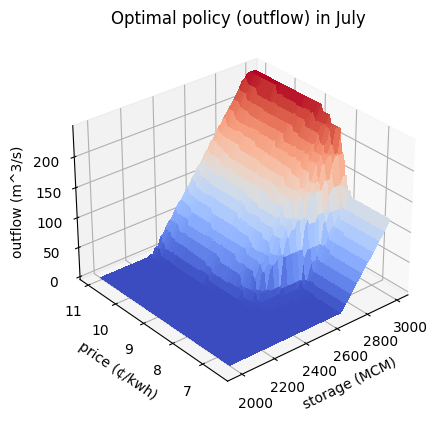

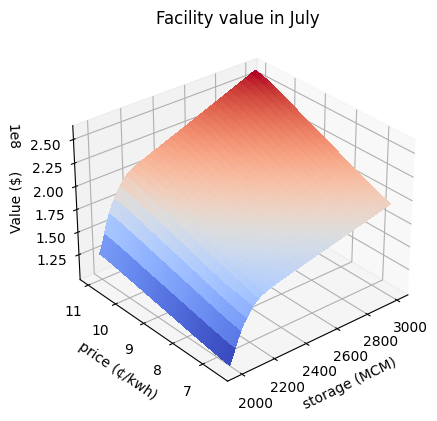

In [18]:
plot_policy(storage_grid[l_d : l_u+1], price_grid, loaded_policy[6][l_d:l_u+1,:])
plot_value(storage_grid[l_d : l_u+1], price_grid, loaded_V0[6][l_d:l_u+1,:]/100)

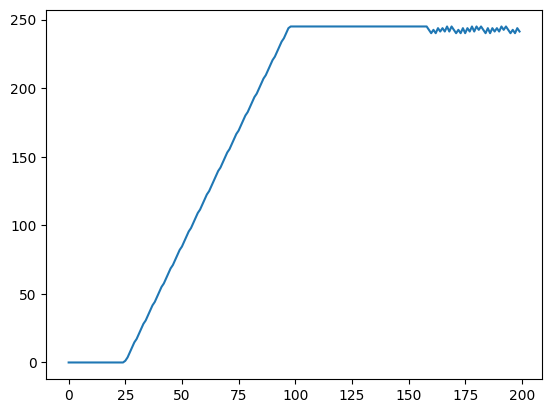

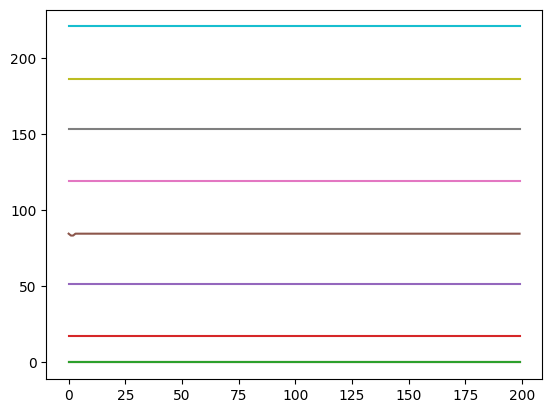

In [21]:
plt.plot(loaded_policy[2,:,30])
plt.show()
for i in range(10):
    plt.plot(loaded_policy[2,10*i,:])
plt.show()

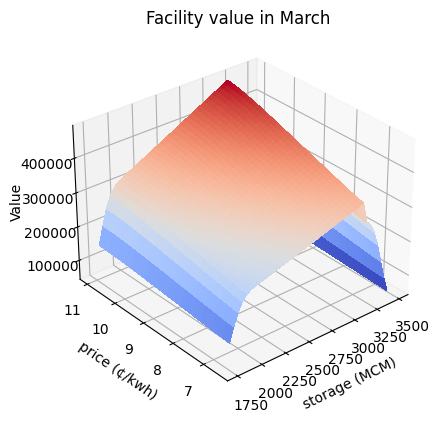

In [68]:
plot_value(storage_grid, price_grid, loaded_V0[2])

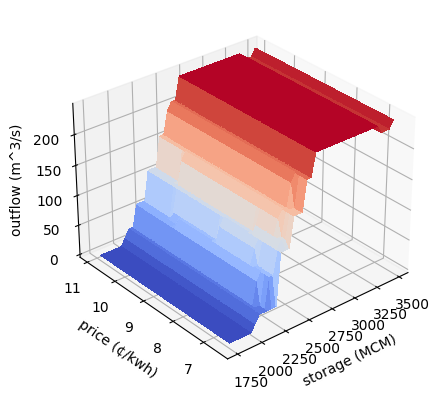

In [36]:
plot_policy(storage_grid, price_grid, loaded_policy[11])

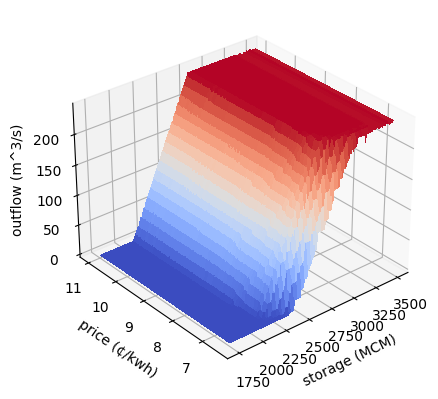

In [13]:
plot_policy(storage_grid,price_grid,loaded_policy[10])

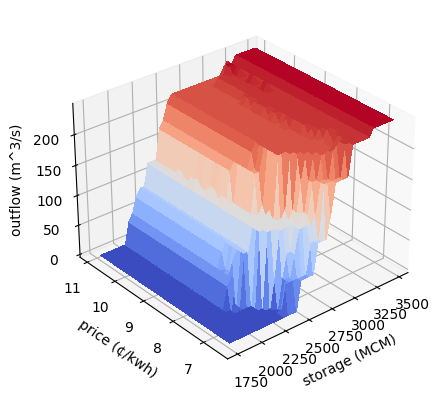

8.456173706701858
0


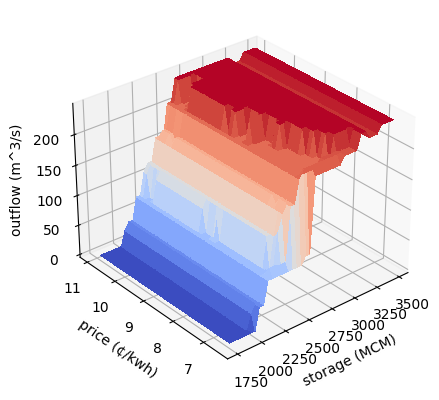

8.478153403512536
1


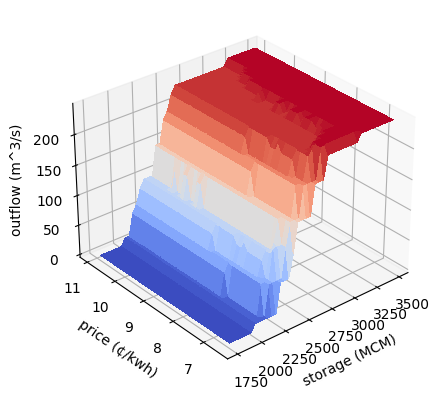

8.331259393621359
2


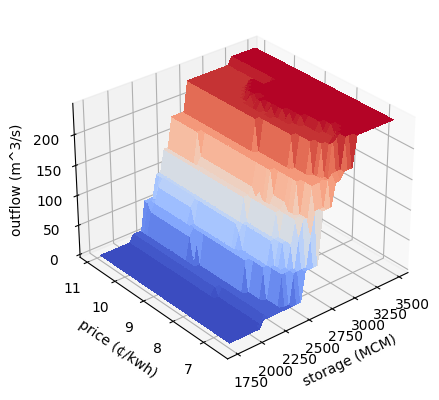

8.1696856869195
3


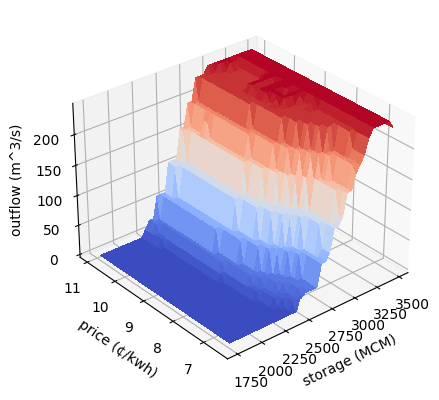

8.162305990108822
4


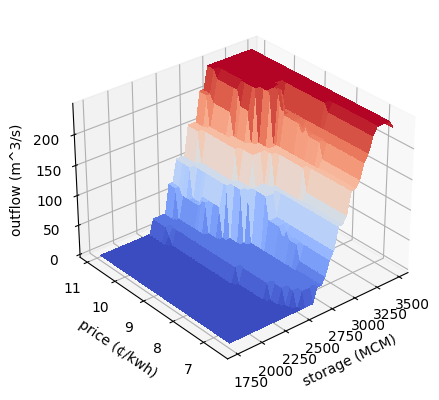

8.323799999999999
5


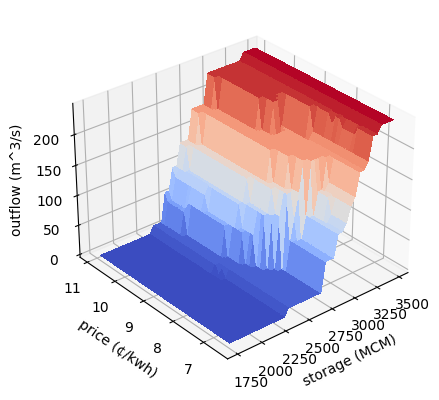

8.499973706701859
6


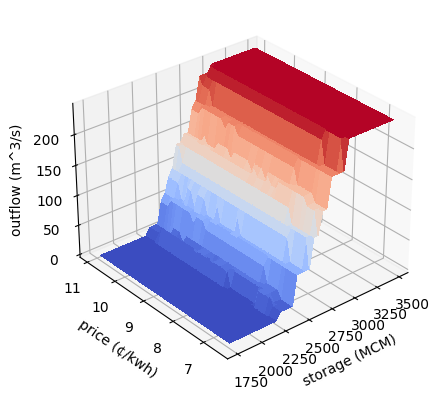

8.521953403512535
7


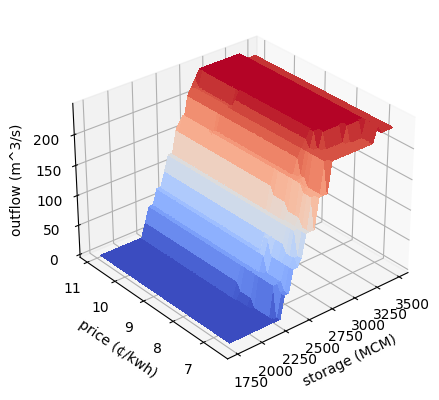

8.375059393621354
8


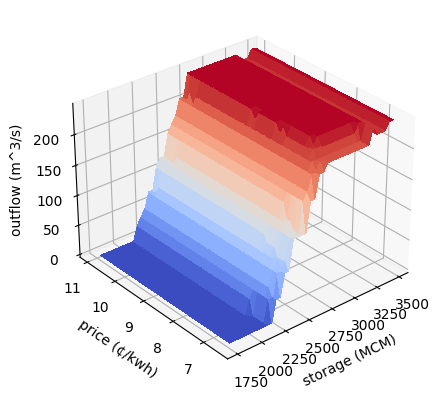

8.213485686919496
9


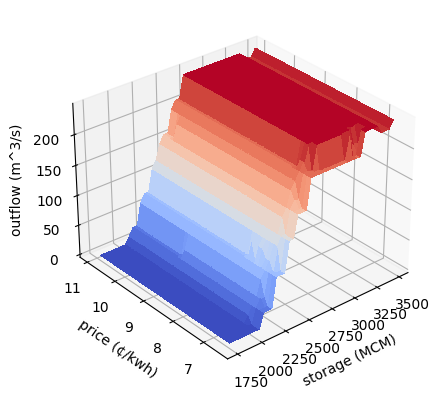

8.206105990108819
10


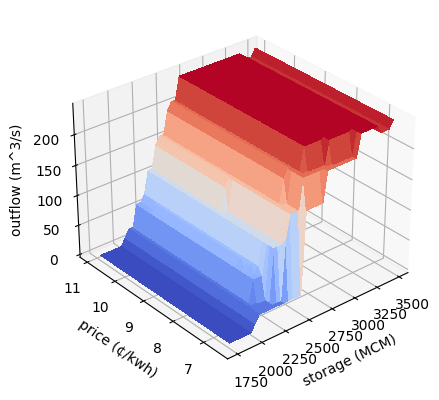

8.3676
11


In [69]:
for s in range(12):
    plot_policy(storage_grid,price_grid,loaded_policy[s])
    print(ts_forecast.loc[time_0+s, 'price'])
    print(s)

## Simulation of optimal policy

In [19]:
interval = S // 10

def simulating_paths(loaded_policy,T = 10000, t0 = time_0, storage_0 = ts_forecast.loc[ts_forecast.index.values[time_0 - 1], 'storage'],
                     price_e_0 = ts_forecast.loc[ts_forecast.index.values[time_0 - 1], 'price_power']
                     , inflow_0 = ts_forecast.loc[ts_forecast.index.values[time_0 - 1], 'inflow'],
                     price_w_0 = ts_forecast.loc[ts_forecast.index.values[time_0 - 1], 'water_prices'],
                    cashflow_e = np.zeros((S,N,M,W)), cashflow_w = np.zeros((S,N,M,W))):
    
    z_s = np.random.randn(T,S)
    z_p_hat = np.random.randn(T,S)
    z_p = correlation * z_s + np.sqrt(1-correlation**2) * z_p_hat
    z_w = np.random.randn(T,S)
    
    storage = np.zeros((T,S+1))
    storage[:,0] = storage_0
    
    inflow = np.zeros((T,S+1))
    inflow[:,0] = inflow_0
    
    price_e = np.zeros((T,S+1))
    price_e[:,0] = price_e_0
    
    price_w = np.zeros((T,S+1))
    price_w[:,0] = price_w_0
    
    
    cashflow_sim_e = np.zeros((T,S))
    cashflow_sim_w = np.zeros((T,S))
    
    outflows_grid = np.zeros((T,S))

    for s in range(S):
        current_time = time_0 + s
        
        storage_coord, _ = prepro_coord_array_numba(storage[:,s], storage_grid)
        price_e_coord, _ = prepro_coord_array_numba(price_e[:,s], price_grid_e)
        price_w_coord, _ = prepro_coord_array_numba(price_w[:,s], price_grid_w)
        
#         print(storage_coord)
#         print(len(price_e_coord))
#         print(len(price_w_coord))
        
#         print('=' * 70)
        storage_coord = coord_array_numba(storage_coord, storage_grid, step_storage)
        price_e_coord = coord_array_numba(price_e_coord, price_grid_e, step_price_e)
        price_w_coord = coord_array_numba(price_w_coord, price_grid_w, step_price_w)
        
        
#         print(storage_coord.shape)
#         print(price_e_coord.shape)
#         print(price_w_coord.shape)
#         print(loaded_policy[s,:,:,:].shape)
        outflows = loaded_policy[s,:,:,:][storage_coord, price_e_coord, price_w_coord]
        outflows_grid[:,s] = outflows
        
        #print(outflows)
        
        input_next_storage = [model_inflow, ts_forecast.loc[ts_forecast.index.values[current_time - 1],'inflow'] , model_evaporation, current_time,
                                              storage[:,s], outflows, model_storage] # Outflow changed from IV loop

        
        cashflow_sim_w[:,s] = cashflow_w[s,:,:,:][storage_coord, price_e_coord, price_w_coord]
        cashflow_sim_e[:,s] = cashflow_e[s,:,:,:][storage_coord, price_e_coord, price_w_coord]
        
        storage[:,s+1] = next_storage(*input_next_storage, z_s[:,s])
        inflow[:, s+1] = model_inflow(inflow[:,s], current_time)
        price_e[:,s+1] = next_price_2_rever_numba(current_time, price_e[:,s], z_p[:,s]) # adjust the price model
        price_w[:,s+1] = next_water_price_numba(price_w[:,s], (current_time - 1) % 12, z_w[:,s])
    
    return storage, price_e, price_w, outflows_grid, inflow, cashflow_sim_e, cashflow_sim_w

def model_2_cte(t,prev):
    return prev + coefs_prices_cte_2[0] +  coefs_prices_cte_2[1] * (np.sin((t+coefs_prices_cte_2[2])*2*np.pi/6)) + coefs_prices_cte_2[3] * (np.sin((t+coefs_prices_cte_2[4])*2*np.pi/12))
def next_price_2_cte(t, prev, shock_m):
    return model_2_cte(t, prev)  + prices_2_cte_sd * shock_m

def plot_conf_int_boot(l, sample,quantiles_2 = [0.005, 0.995], quantiles = [0.05, 0.95], var_name = 'noname'):

    T = sample.shape[0]
    S = sample.shape[1]

    i_5  = int(T*quantiles[0])
    i_95 = int(T*quantiles[1])
    i_50 = int(T*0.5)
    i_05 = int(T*quantiles_2[0])
    i_995= int(T*quantiles_2[1])
    
    S_bis = S - 10
    toptop = np.zeros(S_bis)
    top = np.zeros(S_bis)
    med = np.zeros(S_bis)
    bot = np.zeros(S_bis)
    botbot = np.zeros(S_bis)
    
    for t in range(S_bis):

        sample_t = sorted(sample[:,t])

        toptop[t] = sample_t[i_995]
        top[t] = sample_t[i_95]
        med[t] = sample_t[i_50]
        bot[t] = sample_t[i_5]
        botbot[t] = sample_t[i_05]


    fig, (ax) = plt.subplots(1, 1, sharex=True)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))

    ax.plot(l, med , color='black', label = 'Median')
    ax.fill_between(l, bot, top, where=top >= bot, facecolor='green', interpolate=True, alpha = 0.7, label= '5% - 95% confidence interval')
    ax.fill_between(l, botbot, bot, where=bot >= botbot, color='#70d567', interpolate=True, alpha = 0.7, label= '0.5% - 99.5% confidence interval')
    ax.fill_between(l, top, toptop, where=toptop >= top, color='#70d567', interpolate=True, alpha = 0.7)
    
    plt.gcf().autofmt_xdate()
    plt.legend()
    #plt.title(f'Forward simulation: {T} trajectories ',fontdict={'size':'18'})
    plt.ylabel(var_name,fontdict={'size':'16'})
    plt.xlabel('Months',fontdict={'size':'16'})
    plt.grid()
    #plt.tight_layout()
    
    return None
    

In [20]:
storage_sim, price_e_sim, price_w_sim, outflows_sim, inflow, sim_cf_e, sim_cf_w = simulating_paths(loaded_policy= loaded_policy, cashflow_e=cashflow_e, cashflow_w=cashflow_w)

In [21]:
l = []
for s in range(S-10):
    if s % 12 == 0:
        l.append(f'Dec{19+math.ceil(s/12)}')
    if s % 12 == 1:
        l.append(f'Jan{19+math.ceil(s/12)}')
    if s % 12 == 2:
        l.append(f'Feb{19+math.ceil(s/12)}')
    if s % 12 == 3:
        l.append(f'Mar{19+math.ceil(s/12)}')
    if s % 12 == 4:
        l.append(f'Apr{19+math.ceil(s/12)}')
    if s % 12 == 5:
        l.append(f'May{19+math.ceil(s/12)}')
    if s % 12 == 6:
        l.append(f'Jun{19+math.ceil(s/12)}')
    if s % 12 == 7:
        l.append(f'Jul{19+math.ceil(s/12)}')
    if s % 12 == 8:
        l.append(f'Aug{19+math.ceil(s/12)}')
    if s % 12 == 9:
        l.append(f'Sep{19+math.ceil(s/12)}')
    if s % 12 == 10:
        l.append(f'Oct{19+math.ceil(s/12)}')
    if s % 12 == 11:
        l.append(f'Nov{19+math.ceil(s/12)}')

In [22]:
l = ts_forecast.index.values[time_0-1:time_0 + S]

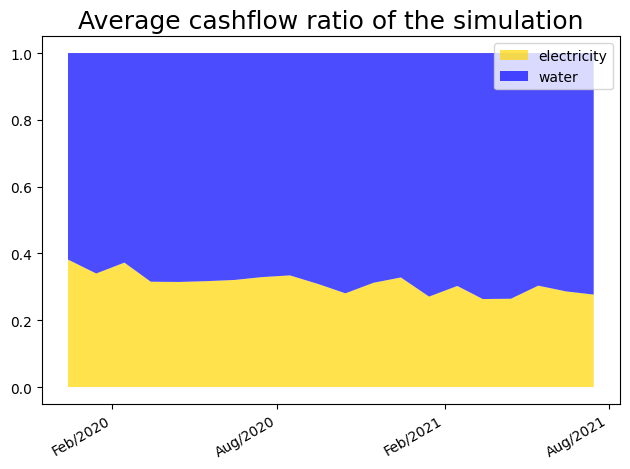

In [23]:
cut = sim_cf_e.mean(axis= 0) / (sim_cf_e.mean(axis= 0) +   sim_cf_w.mean(axis= 0))

bot = np.zeros(len(cut))
top = np.ones(len(cut))

fig, (ax) = plt.subplots(1, 1, sharex=True)
    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

ax.fill_between(l, bot, cut, where=cut >= bot, facecolor='gold', interpolate = True, alpha = 0.7, label= 'electricity')
ax.fill_between(l, top, cut, where=top >= cut, facecolor='blue', interpolate = True, alpha = 0.7, label= 'water')

plt.legend()
plt.title('Average cashflow ratio of the simulation',fontdict={'size':'18'})

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig('Figures/paper/cf_ratios.pdf', format='pdf')

plt.show()

In [24]:
l = ts_forecast.index.values[time_0-1:time_0 + S-10]

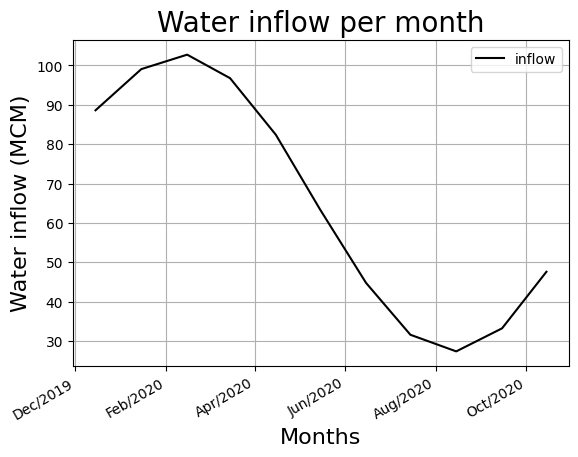

In [25]:
ax = plt.gca()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))

plt.plot(l, inflow[0,:-10], color = 'black', label = 'inflow')
# plt.locator_params(axis='x', nbins=10)

plt.gcf().autofmt_xdate()

plt.legend()
plt.ylabel('Water inflow (MCM)',fontdict={'size':'16'})
plt.xlabel('Months',fontdict={'size':'16'})
plt.grid()
plt.title('Water inflow per month',fontdict={'size':'20'})
# plt.savefig('Figures/paper/water_inflow.pdf', format='pdf')
plt.show()

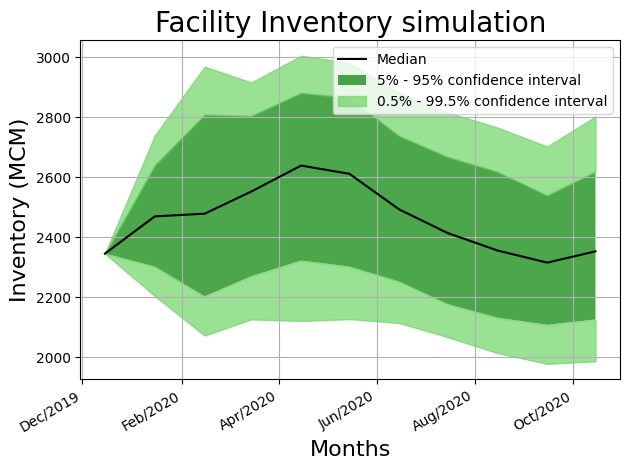

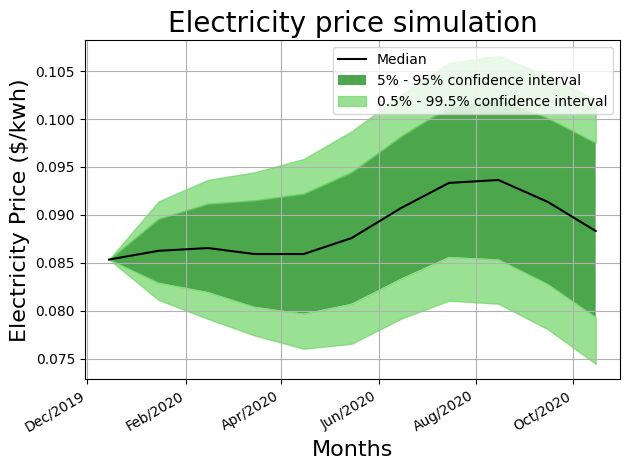

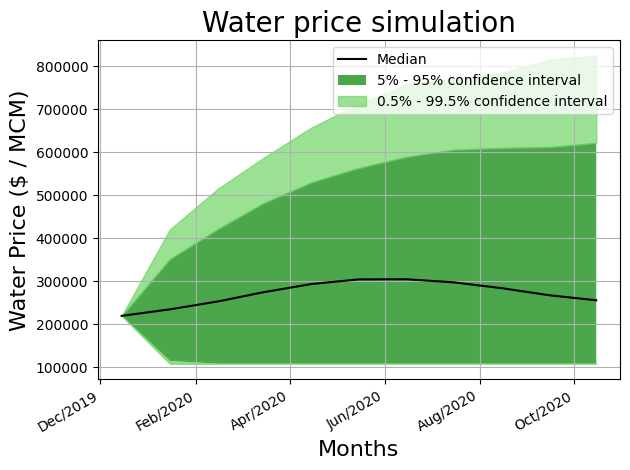

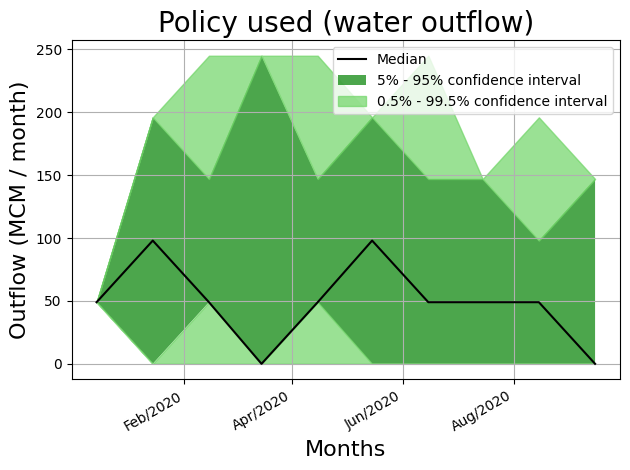

In [27]:
mr            = True
one_component = False
S_bis = S-10


plot_conf_int_boot(l, storage_sim, var_name = 'Inventory (MCM)')
plt.title('Facility Inventory simulation',fontdict={'size':'20'})
# plt.xticks(range(S_bis), labels=l)
# plt.locator_params(axis='x', nbins=10)
plt.tight_layout()

if one_component:
    if mr:
        plt.savefig('Figures/paper/inventory_conf_int.pdf', format='pdf')
    else:
        plt.savefig('Figures/paper/inventory_conf_int_nonmr.pdf', format='pdf')
else:
    if mr:
        plt.savefig('Figures/paper/inventory_conf_int_2.pdf', format='pdf')
    else:
        plt.savefig('Figures/paper/inventory_conf_int_nonmr_2.pdf', format='pdf')
        
plot_conf_int_boot(l, price_e_sim, var_name = 'Electricity Price ($/kwh)' )
plt.title('Electricity price simulation',fontdict={'size':'20'})
# plt.xticks(range(S_bis), labels=l)
# plt.locator_params(axis='x', nbins=10)
plt.tight_layout()

if one_component:
    if mr:
        plt.savefig('Figures/paper/price_e_conf_int.pdf', format='pdf')
    else:
        plt.savefig('Figures/paper/price_e_conf_int_nonmr.pdf', format='pdf')
else:
    if mr:
        plt.savefig('Figures/paper/price_e_conf_int_2.pdf', format='pdf')
    else:
        plt.savefig('Figures/paper/price_e_conf_int_nonmr_2.pdf', format='pdf')

        
plot_conf_int_boot(l, price_w_sim, var_name = 'Water Price ($ / MCM)')
plt.title('Water price simulation',fontdict={'size':'20'})
# plt.xticks(range(S_bis), labels=l)
# plt.locator_params(axis='x', nbins=10)
plt.tight_layout()

if one_component:
    if mr:
        plt.savefig('Figures/paper/price_w_conf_int.pdf', format='pdf')
    else:
        plt.savefig('Figures/paper/price_w_conf_int_nonmr.pdf', format='pdf')
else:
    if mr:
        plt.savefig('Figures/paper/price_w_conf_int_2.pdf', format='pdf')
    else:
        plt.savefig('Figures/paper/price_w_conf_int_nonmr_2.pdf', format='pdf')


plot_conf_int_boot(l[:-1], outflows_sim, var_name = 'Outflow (MCM / month)')
plt.title('Policy used (water outflow)',fontdict={'size':'20'})
# plt.xticks(range(S_bis), labels=l)
# plt.locator_params(axis='x', nbins=10)
plt.tight_layout()

if one_component:
    if mr:
        plt.savefig('Figures/paper/outflow_conf_int.pdf', format='pdf')
    else:
        plt.savefig('Figures/paper/outflow_conf_int_nonmr.pdf', format='pdf')
else:
    if mr:
        plt.savefig('Figures/paper/outflow_conf_int_2.pdf', format='pdf')
    else:
        plt.savefig('Figures/paper/outflow_conf_int_nonmr_2.pdf', format='pdf')
plt.show()